# Packages & libraries


We report below all the necessary packages and libraries.

In [1]:
import subprocess
import sys

# Check if the 'rouge' package is installed
try:
    import rouge
except ImportError:
    # If not installed, install it using pip
    print(f"rouge not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge"])
else:
    print(f"rouge is already installed.")

rouge is already installed.


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import random
from tqdm import tqdm
from collections import Counter

# Libraries for text processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Libraries for sparse matrix operations
from scipy.sparse import lil_matrix

# Libraries for performance evaluation
import time
import tracemalloc 
from rouge import Rouge

In [3]:
# Download the required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eleon\AppData\Roaming\nltk

True

# Dataset construction

For our simulations, we use the CNN/DailyMail dataset, an English-language dataset containing over $300,000$ unique news articles written by journalists from CNN and the Daily Mail. Each instance in the dataset consists of the following three features:
- `id`: A string containing the hex-formatted hash of the URL where the story was retrieved.
- `article`: A string containing the body of the news article.
- `highlights`: A string containing a summary of the article as written by the author.

The dataset is provided in three splits: train, validation, and test. For our purposes, which do not require separate validation or testing phases, we combine all three splits into a single dataset, called `df_original`.

In [4]:
path = ''
df_train = pd.read_csv(f"{path}Data/train.csv")
df_validation = pd.read_csv(f"{path}Data/validation.csv")
df_test = pd.read_csv(f"{path}Data/test.csv")
# Concatenate the DataFrames 'df_train', 'df_validation', and 'df_test' along the rows
df_original = pd.concat([df_train, df_validation , df_test], axis = 0, ignore_index = True)
df_original

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...,...
311963,ed8674cc15b29a87d8df8de1efee353d71122272,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...
311964,2f58d1a99e9c47914e4b1c31613e3a041cd9011e,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...
311965,411f6d57825161c3a037b4742baccd6cd227c0c3,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...
311966,b5683ef8342056b17b068e0d59bdbe87e3fe44ea,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...


Each hand-written summary in `highlights` contains a different number of sentences. We analyze the distribution of the number of sentences in `highlights` using the following countplots.

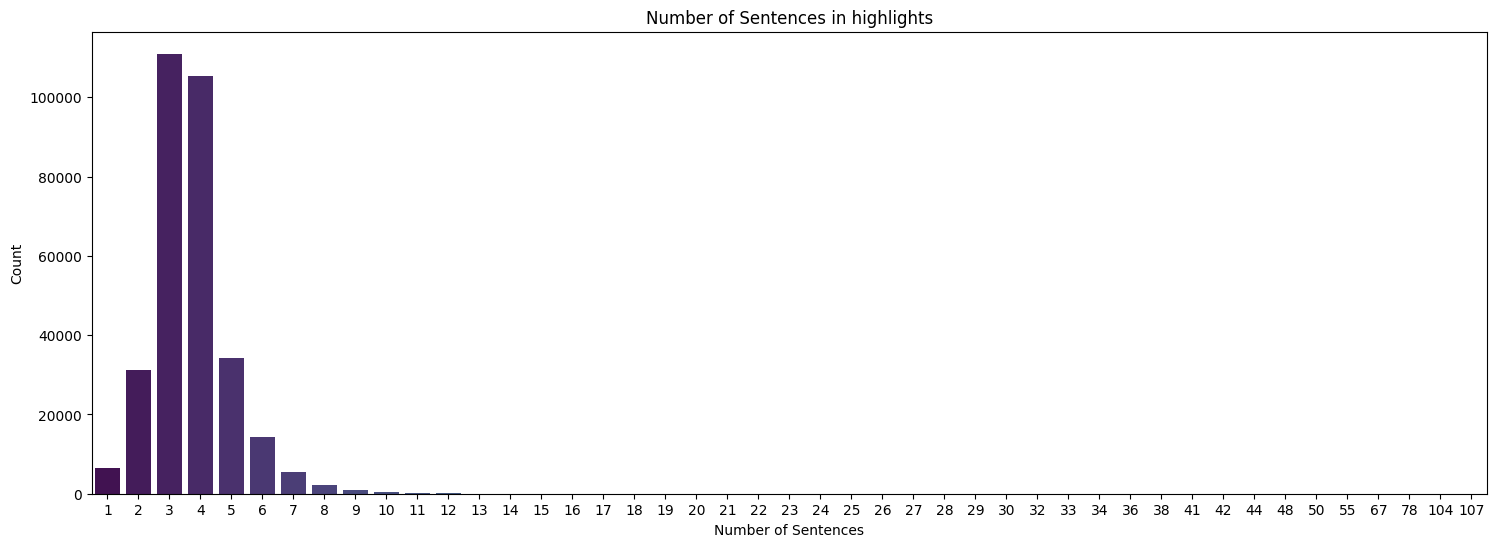

In [5]:
def count_sentences(text):
    '''
    Counts the number of sentences in a given text.

    Parameters:
    text (str): The input text from which sentences will be counted.

    Returns:
    int: The number of sentences in the input text.
    '''
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

# Count the number of sentences in each 'highlight'
df_original['num_sentences_hs'] = df_original['highlights'].apply(count_sentences)

# Plot a count plot for the 'num_sentences_hs' column
plt.figure(figsize = (18, 6))
sns.countplot(x = 'num_sentences_hs', data = df_original, palette = 'viridis') # Add hue = 'num_sentences_hs' on google Colab
plt.title('Number of Sentences in highlights')
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.show()

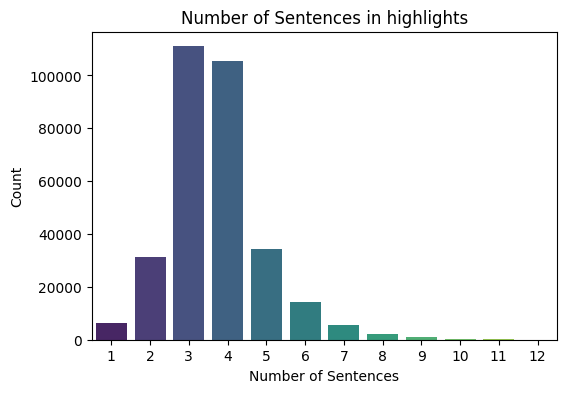

In [6]:
# Plot the countplot restricted to number of sentences in highlights <= 12
plt.figure(figsize = (6, 4))
sns.countplot(x = 'num_sentences_hs', data = df_original[df_original['num_sentences_hs'] <= 12], palette = 'viridis') # Add hue = 'num_sentences_hs' on google Colab
plt.title('Number of Sentences in highlights')
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.show()

To align with the objective of this project, we restrict our analysis to the subset of articles whose  `highlights` contain exactly four sentences. The resulting subset includes $105,340$ articles.

In [7]:
# Filter the DataFrame 'df_original' to only include rows where the 'num_sentences_hs' column equals 4
df_original = df_original[df_original['num_sentences_hs'] == 4].reset_index(drop = True)
# Drop the 'num_sentences_hs' column from the DataFrame since it is no longer needed
df_original = df_original.drop(columns = ['num_sentences_hs'])

In [8]:
# Display information about the DataFrame 'df_original', including the number of entries, column names, data types, and non-null counts. 
# The 'memory_usage = "deep"' option gives a detailed report of the memory usage, including object types like strings, which are not fully captured by the default memory usage option.
df_original.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105340 entries, 0 to 105339
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          105340 non-null  object
 1   article     105340 non-null  object
 2   highlights  105340 non-null  object
dtypes: object(3)
memory usage: 623.0 MB


## Data cleaning

To ensure the dataset’s quality and consistency, we apply several preprocessing steps to clean the data.

### 1) Removing duplicates

The dataset contains duplicate entries with identical articles and highlights but different IDs. We remove these duplicates to prevent redundancy and ensure each article is processed once. We store the result in the DataFrame `df`.

In [9]:
duplicated_articles = df_original[df_original.duplicated(subset = ['article'], keep = False)]
duplicated_articles.sort_values(by = 'article')

,id,article,highlights
9582,50149c383b460f4af1dea04a9912c7e907006456,"'SINDH KALAY', England (CNN) -- The aroma of f...",British soldiers train in mock Afghan village ...
63599,7eb0f5fe50f3debdc83a1673e4acc14920b194b5,"'SINDH KALAY', England (CNN) -- The aroma of f...",British soldiers train in mock Afghan village ...
30924,00f3a0d78fb0ec0152f8467dc7f12310f482c1b0,"'What a nice coat, ma'am.' That's all Texas fa...",Cheryl Semien has been at Whattaburger in Libe...
36295,15e12d1549d1246e8878887f574a6d0c29db56d7,"'What a nice coat, ma'am.' That's all Texas fa...",Cheryl Semien has been at Whattaburger in Libe...
61090,74f585830933718eb3fdb9d42f79a29fbae83bf4,(AOL Autos) -- Collecting cars is an expensiv...,The right new car today could be worth a fortu...
...,...,...,...
3033,19223605e0287809a065f145050147a69f2ef02b,"You wanted to know more about greenwashing, an...",Scot Case answers your questions on greenwashi...
21305,b24ccfaffed3ba9df524010b1fd9a57b1c2123a7,You've been told for years that popping a mult...,Stick with mainstream names found to be free o...
95389,f8fb85f3de36eca7d1c7e907af7c0f9e8b246e28,You've been told for years that popping a mult...,Stick with mainstream names found to be free o...
52595,540ac491c49625e5bc117e8f09e5e2a7e8748019,"ZHOUSHAN, China (CNN) -- They operate from a ...",Chinese hackers claim to have broken into Pent...


In [10]:
df = df_original.copy()
df = df.drop_duplicates(subset = 'article')

### 2) Cleaning highlights

For each instance of the dataset the sentences in the `highlights` column are separated by ’\n’. We remove these newline characters to avoid potential issues with the `rouge` evaluation package. We show below as an example the first entry of the dataset before and after the cleaning (one can verify that the same happens for every other entry of `df`).

In [11]:
df.loc[0]['highlights']

'Black box data from Flight 370 could be analyzed at a laboratory in Australia .\nEven if the flight data recorder is damaged, information is retrievable .\nAbout 2,000 parameters are decoded, like altitude, engine performance and cabin pressure .\nThe data is used to create a visual representation, helping the public understand an accident .'

In [11]:
# We use regular expressions to remove newline characters
df['highlights'] = df['highlights'].str.replace("\n", ' ', regex = True)
df['highlights'] = df['highlights'].str.replace(r'\s+\.', '.', regex = True)

In [13]:
df.loc[0]['highlights']

'Black box data from Flight 370 could be analyzed at a laboratory in Australia. Even if the flight data recorder is damaged, information is retrievable. About 2,000 parameters are decoded, like altitude, engine performance and cabin pressure. The data is used to create a visual representation, helping the public understand an accident.'

Additionally, as we can see below, some highlights begin with the word 'NEW:'. We remove this prefix as it is not part of the summary’s semantic content. At the end, we show as examples the first two highlights below, after cleaning.

In [14]:
df[df['highlights'].str.contains(r'^NEW: ', regex = True)]['highlights']

11       NEW: State media report four deaths, 40 injuri...
14       NEW: Police make an arrest. Authorities say Ma...
19       NEW: Palestinian security forces say they will...
20       NEW: Next terror attack on U.S. likely to orig...
51       NEW: Father of alleged murder victim objects t...
                               ...                        
97080    NEW: As many as 37 people are dead in the fire...
97082    NEW: Two of the wounded are Americans. The top...
97110    NEW: State media reports 27 civilians are kill...
97139    NEW: Timothy Geithner to be announced as Treas...
97161    NEW: An opposition leader says crackdown, not ...
Name: highlights, Length: 6706, dtype: object

In [12]:
df['highlights'] = df['highlights'].str.replace(r'^NEW: ', '', regex = True)

In [16]:
# We double check to be sure that all instances of "NEW:" were removed from the beginning of the highlights
df[df['highlights'].str.contains(r'^NEW: ', regex = True)]

,id,article,highlights


In [17]:
# Examples after cleaning
df.loc[[11, 14]]['highlights']

11    State media report four deaths, 40 injuries. A...
14    Police make an arrest. Authorities say Matthew...
Name: highlights, dtype: object

### 3) Removing metainformation in articles

The articles often contain extraneous metainformation, particularly at the beginning, which are irrelevant to the summarization task. Below are the types of metainformation identified. 

1) Articles starting with (CNN) --, (CNN), or other journal/websites names in parentheses (e.g., (Rolling Stone), (CNET), (EW.com)), eventually preceded by city and/or country names.

In [18]:
# Artcles starting with names in parenthesis eventually followed by --
df[df['article'].str.contains(r'^\(.*?\)(?:\s*--)?', regex = True)]['article']

1         (CNN) -- One can hardly read the news these da...
8         (CNN) -- A University of Wisconsin senior offi...
9         (CNN) -- Returning home from the London 2012 P...
10        (CNN) -- While the Tour de France ambles aroun...
11        (CNN) -- After weeks of relative calm, clashes...
                                ...                        
104942    (CNN)That's some rich "American Pie." The lyri...
104976    (CNN)They're not gonna take it anymore. Really...
105215    (CNN)Looting, fires and violence descended on ...
105288    (CNN)If newly revised NYPD training materials ...
105307    (CNN)You might call her a watchdog, because th...
Name: article, Length: 24952, dtype: object

It seems from above that only CNN appears inside the parentheses, but there are actually other journal or websites names such as Rolling Stone, CNET, EW.com, Mental Floss and others. We show it below.

In [19]:
indices = [135, 150, 205, 389]

for i in indices:
    print(f"{i}\n{df.loc[i]['article']}")

135
(Rolling Stone) -- The digital archivist who restored the singles catalogs of the Smiths, Joy Division and New Order in a series of blog projects is being strongly discouraged from starting a similar project collecting R.E.M.'s earliest work. In a blog post on the nascent R.E.M.cycle site, the blogger known as Analog Loyalist explained that Universal, the record company that owns the band's IRS Records catalog, issued a Digital Millennium Copyright Act (DMCA) takedown notice for an R.E.M. post on the writer's sister site The Power of Independent Trucking featuring a restored version of the band's first cassette demo, with early renditions of "Radio Free Europe," "Sitting Still" and "White Tornado." "Tell me, what role does the IFPI (of which Universal is obviously a member) have to do with unreleased material recorded when the band had no record contract?," Analog Loyalist writes, referring to the International Federation of the Phonographic Industry. "These were demos freely given

It might also happen that the names inside the parentheses are preceded by city and/or country names. We show it for CNN below, but it can be verified also for other names such as Financial Times, Reuters and some others.

In [20]:
df[df['article'].str.contains(r'^\w+.*?\(CNN\)(?:\s*--)?', regex = True)]['article']  

0         Canberra, Australia (CNN) -- At first glance, ...
20        WASHINGTON (CNN)  -- Terrorists are likely to ...
21        CAVITE CITY, Philippines (CNN)  -- At 16, Rhan...
30        BERLIN, Germany (CNN) -- A German cruise liner...
51        Los Angeles (CNN) -- A Fullerton, California, ...
                                ...                        
102760    Phoenix, Arizona (CNN)Nearly 12 million parent...
103278    Surkhet, Nepal (CNN)Ten years ago, with her hi...
103291    New York  (CNN)New York's iconic Statue of Lib...
104047    Miami (CNN)Despite the glitz and glamour Miami...
104855    Boston (CNN)Now the real Boston Marathon trial...
Name: article, Length: 13591, dtype: object

We store all the journal/websites names in the `names` list below and use a regular expression that covers all the cases mentioned above to remove text. Notice that the names in the list can appear with upper or lower case and eventually with .com at the end. We incorporate all these possibilities in the same regular expression.

In [13]:
# List of the journal/websites names appearing in parentheses, regardless of case and eventually followed by .com
names = ['CNN', 'CNN Student News', 'CNN Espanol', 'Rolling Stone', 'RollingStone', 'CNET', 'EW', 'Mental Floss', 'MentalFloss', 'AOL Autos', 'Time', 'Careerbuilder', 'Oprah', 'People', 'Mashable', 'Entertainment Weekly', 'Financial Times', 'The Frisky', 'LifeWire', 'Wired', 'Ars Technica', 'InStyle', 'Real Simple', 'RealSimple', 'Health', 'Parenting', 'Reuters', 'Motor Sport', 'VBS.TV', 'Save The Children', 'Business Insider', 'Upwave', 'Uwire', 'MNN', 'Budget Travel', 'Travel \+ Leisure', 'HLNtv', 'CNNGo', 'Tribune Media Services', 'Southern Living', 'ESSENCE', 'This Old House', 'RS']

for name in names:
    # For each name replace the pattern with empty string in the 'article' column to remove the first type of metainformation
    pattern = r'^.*?\(\s*' + name + r'(?:\.com)?\s*\)(?:\s*--\s*)?'
    df['article'] = df['article'].str.replace(pattern, '', regex = True, flags = re.IGNORECASE)

We check if all the names inside the parentheses have been removed from the beginning of the articles.

In [22]:
df[df['article'].str.contains(r'^\(.*?\)(?:\s*--)?', regex = True)]['article']

26358    (CNN) -- The words "budget" and "compromise" h...
61802    (CNN) -- The hostage standoff in St. Joseph, L...
65090    (CNN) -- Two skiers missing after a weekend av...
73164    (CNN) -- Malaysia Airlines flight carrying 239...
Name: article, dtype: object

As we can see, there are four articles in which (CNN) -- has not been removed. Therefore, we compare these articles before and after the cleaning to see why the above regular expression didn't work.

In [23]:
indices = [26358, 61802, 65090, 73164]

for i in indices:
    print(f"{i}\n{df_original.loc[i]['article']}")
    print(df.loc[i]['article'])

26358
Washington (CNN) -- (CNN) -- The words "budget" and "compromise" haven't been connected in Congress in recent years. But legislators stunned observers and perhaps each other this week when Republicans and Democrats proved that they can, indeed, agree on government spending. Republican Rep. Paul Ryan and Democratic Sen. Patty Murray worked out a budget framework to fund the government into 2015. The House approved the compromise agreement Thursday. The measure now goes to the Senate, where it is expected to pass as early as next week. The White House supports the proposal. It was the first full budget agreement by a divided Congress -- in which different parties control the House and Senate -- since 1986, Ryan boasted in announcing the deal. After years of bruising political fights over spending and the federal borrowing limit, dysfunction reigned supreme in October when the government shut down for 16 days. A short-term spending plan got it going again, but a CNN/ORC Internationa

The problem here is that (CNN) -- appears twice. So, we need to apply the same regular expression again to remove the second occurrence.

In [14]:
name = 'CNN'
pattern = r'^.*?\(\s*' + name + r'(?:\.com)?\s*\)(?:\s*--\s*)?'
df['article'] = df['article'].str.replace(pattern, '', regex = True, flags = re.IGNORECASE)

In [25]:
# We double check to be sure that this time we eliminated all the occurrencies of (CNN) --
df[df['article'].str.contains(r'^\w+.*?\(CNN\)(?:\s*--)?', regex = True)]

,id,article,highlights


2) Articles beginning with CNN −− or names in formats 'City, Country' followed by −−.

In [26]:
df[df['article'].str.contains(r'^CNN\s*--', regex = True)]['article'].head()

3532     CNN  -- As one of the most successful franchis...
7523     CNN -- The UN Climate Change Conference in Cop...
14679    CNN -- Fernando Alonso insists Ferrari will bo...
16494    CNN -- One evening in the spring of 2010, Keit...
18255    CNN -- Getting enough rest should be as simple...
Name: article, dtype: object

In [27]:
df[df['article'].str.contains(r'^\w+\s*[.,]+\s*\w+\s*--', regex = True)]['article'].head()

4535     LONDON, England  -- Models younger than 16 sho...
6694     LAGOS, Nigeria -- Incident details: "Armed pir...
8088     CIMA, California  -- Driving along a pockmarke...
10763    NAPLES, Italy -- Udinese remained in fifth pla...
13924    HOUSTON, Texas -- Six-year-old Valentin Marroq...
Name: article, dtype: object

$\textit{Remark}:$ It has been observed that CNN is the only name consistently appearing at the beginning of articles, followed directly by -- without parentheses. Notably, this pattern does not occur for any other name in the `names` list, nor have we identified other names for which this happens. Additionally, we confirm that names formatted as 'City, Country' also appear at the beginning of articles, followed by --. To ensure completeness, we also explored other combinations, including for example cases where city or country names consist of two words, such as 'Los Angeles'.

3) Articles starting with 'By . [Author Name]’, eventually followed by other metadata beginning with 'PUBLISHED: .', 'UPDATED: .', 'Follow @@', 'CREATED: .', 'Last updated' or other author names (or combinations of these), regardless of case.

In [28]:
df[df['article'].str.contains(r'^By\s*\.', regex = True)]['article'].head()

16    By . Chris Pleasance . PUBLISHED: . 08:09 EST,...
23    By . John Hall . Scam: Patricia Glancy conned ...
27    By . Neil Sears . PUBLISHED: . 12:00 EST, 27 D...
33    By . Louise Eccles . PUBLISHED: . 07:47 EST, 1...
36    By . Oliver Todd . Follow @@oliver_todd . The ...
Name: article, dtype: object

We show below examples of various possibilities.

In [29]:
indices = [16, 36, 44, 93, 181, 1269, 51656]

for i in indices:
    print(f"{i}\n{df.loc[i]['article']}")

16
By . Chris Pleasance . PUBLISHED: . 08:09 EST, 15 September 2013 . | . UPDATED: . 06:05 EST, 16 September 2013 . With divorce fast becoming the norm it seems true love is harder and harder to find these days. But as these letters reveal, one smitten couple found a love so strong it was able to endure even while they were separated during World War II. Not only that, it lasted for a total of 70 years of marriage until they both died in 2011, he aged 96 and she aged 92, within just three days of one another. How time passes: Frederick and Elizabeth Noble wed on New Year's Day 1941 while Frederick . was on 48-hour leave from the Royal Tank Corps and stayed married for . the next 70 years . But, as remarkable as their relationship had seemed in life, in death it was about to give up its biggest and most heartwarming surprise. After Frederick and Elizabeth Noble had passed relatives discovered they had kept 250 love letters, telegrams, notes and Valentine's cards from each other. Their g

Some articles start directly with 'CREATED: .', 'UPDATED: .', 'PUBLISHED: .' or 'Last updated', regardless of case. These sentences will be removed.

In [30]:
df[df['article'].str.contains(r'^CREATED: \.', regex = True, flags = re.IGNORECASE)]['article'].head()

13119    Created: . 09:14 EST, 26 April 2014 . Should u...
37456    Created: . 09:17 EST, 8 August 2014 . A mother...
37602    Created: . 04:08 EST, 19 March 2014 . A Cambri...
48762    Created: . 23:04 EST, 26 February 2015 . This ...
57944    Created: . 08:22 EST, 6 June 2014 . The sun sh...
Name: article, dtype: object

In [31]:
df[df['article'].str.contains(r'^UPDATED: \.', regex = True, flags = re.IGNORECASE)]['article']

13242    UPDATED: . 07:52 EST, 5 October 2011 . The rel...
Name: article, dtype: object

In [32]:
df[df['article'].str.contains(r'^PUBLISHED: \.', regex = True, flags = re.IGNORECASE)]['article'].head()

156     PUBLISHED: . 12:00 EST, 20 September 2012 . | ...
679     PUBLISHED: . 22:58 EST, 21 December 2013 . | ....
974     PUBLISHED: . 10:56 EST, 7 March 2013 . | . UPD...
1562    PUBLISHED: . 10:45 EST, 7 May 2013 . | . UPDAT...
1920    PUBLISHED: . 09:35 EST, 12 September 2013 . | ...
Name: article, dtype: object

In [33]:
df[df['article'].str.contains(r'^Last updated ', regex = True)]['article'].head()

4        Last updated at 3:31 PM on 19th July 2011 . Ch...
43308    Last updated at 2:59 PM on 5th December 2011 ....
49939    Last updated at 5:51 PM on 6th October 2011 . ...
50380    Last updated at 1:31 PM on 4th March 2012 . Th...
68264    Last updated at 3:50 PM on 2nd December 2011 ....
Name: article, dtype: object

4) Articles beginning with a note from the editor introduced by the expression 'Editor’s note:'. All the notes are made of a single sentence, which will be removed.

In [34]:
df[df['article'].str.contains(r'^Editor\'s note:', regex = True, flags = re.IGNORECASE)]['article'].head()

2134    Editor's note: CNN has a business partnership ...
4311    Editor's Note: Christina Blanch is a comics sc...
4520    Editor's note: Below is an excerpt from Larry ...
4522    Editor's note: Below is an excerpt from Nancy ...
6938    Editor's note: In 1994, the American Psychiatr...
Name: article, dtype: object

5) Expressions such as (left), (right) or (pictured) indicating images will be removed.

In [35]:
df[df['article'].str.contains(r'\((?:left|right|pictured)\)', regex = True)]['article'].head()

2     A woman has been charged with reckless manslau...
13    It is one of the key bonding experiences for a...
22    Four police officers involved in the fatal pur...
23    By . John Hall . Scam: Patricia Glancy conned ...
24    The secret to staying slim could be in saliva....
Name: article, dtype: object

6. Articles starting with 'Click here', regardless of case.

In [36]:
df[df['article'].str.contains(r'^Click here', regex = True, flags = re.IGNORECASE)]['article'].head()

246     CLICK HERE to read how the German plans to pip...
433     Click here to find out more from our brilliant...
1329    Click here for your ultimate stats guide to th...
1467    Click here to see more from our brilliant Matc...
1646    Click here for Martin Samuel's match report fr...
Name: article, dtype: object

7. Articles beginning with dates in formats 'Month day, year'. We show examples for April and December.

In [37]:
df[df['article'].str.contains(r'^April ', regex = True)]['article'].head()

2369     April 16, 2014 . A city pays tribute to the me...
3603     April 30, 2014 . Another round of severe weath...
4150     April 28, 2014 . Headlines from South Korea, V...
10010    April 30, 2010 . Arbor Day is awesome! Especia...
10552    April 21, 2014 . Monday's show is global in sc...
Name: article, dtype: object

In [38]:
df[df['article'].str.contains(r'^December', regex = True)]['article'].head()

7104     December 13, 2010 . Hi, I'm Carl Azuz. This is...
7678     December 10, 2013 . The official start of wint...
8752     December 19, 2013 . In our penultimate program...
16092    December 1, 2014 . Preliminary sales from Blac...
16304    December 18, 2013 . As technology executives m...
Name: article, dtype: object

We remove metainformation of type $2$-$6$ using the following regular expressions.

In [15]:
# Define a list of regular expression patterns to remove all metainformation except for type 7
patterns = [
    r'^CNN\s*--\s*', # Reg expr 1
    r'^\w+\s*[.,]+\s*\w+\s*--\s*', # Reg expr 2
    r'^.*?CREATED: \..*?\.\s*', # Reg expr 3
    r'^.*?UPDATED: \..*?\.\s*', # Reg expr 4
    r'^.*?PUBLISHED: \..*?\.\s*', # Reg expr 5
    r'^.*?Last updated at .*?\.\s*', # Reg expr 6
    r'^(By\s*\.\s*.*?\s*\.\s*)(?:((Follow|and)\b.*?\.\s*))?(?:(and\b.*?\.\s*))?', # Reg expr 7
    r'^Editor\'s note:.*?\.\s*', # Reg expr 8
    r'\((left|right|pictured)\)\s*', # Reg expr 9
    r'^Click here.*?\.\s*' # Reg expr 10
]

for pattern in patterns:
    # Replace occurrences of the pattern in the 'article' column with an empty string
    df['article'] = df['article'].str.replace(pattern, '', regex = True, flags = re.IGNORECASE)

Specifically:
1. Regular expression n.1 matches text that starts with CNN, followed by zero or more whitespace characters, then --, and optionally followed by more whitespace characters;
2. Regular expression n.2 matches patterns where a word is followed by punctuation (period or comma), another word, and a -- with optional spaces around it;
3. Regular expression n. 3 matches everything from the start of the string up to and including a phrase that begins with 'CREATED: .' and ends with the next period;
4. Regular expression n. 4 is similar to the previous one, but for phrases that start with 'UPDATED: .';
5. Regular expression n. 5 is similar to the previous two patterns but for phrases that start with 'PUBLISHED: .';
6. Regular expression n. 6 is similar to the previous three patterns but for phrases that start with 'Last updated at';
7. Regular expression n. 7 matches sections of text that start with 'By . Author name/Journal name .', optionally followed by phrases starting with specific words like 'Follow' or 'and'. It also accounts for cases where the 'and' might appear again after the initial phrase;
8. Regular expression n. 8 matches any text starting with 'Editor's note:' up to and including the first period;
9. Regular expression n.9 matches text enclosed in parentheses with the specific words 'left', 'right', or 'pictured' inside, and optional whitespace after the closing parenthesis;
10. Regular expression n.10 matches text that starts with 'Click here' up to and including the first period.

Finally, we remove any inital phrase starting with dates in formats 'Month day, year' (type 7 metainformation).

In [16]:
# List of months
months = ['Jenuary', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for month in months:
    # For each month replace the pattern with empty string in the 'article' column to remove the last type of metainformation
    pattern = r'^' + month + r' \d{1,2}\s*, \d{4}\s*\.\s*'
    df['article'] = df['article'].str.replace(pattern, '', regex = True)

At this point, the `df` DataFrame contains the cleaned data with the above patterns removed. We now double-check the results in `df` before proceding with the reindexing of the DataFrame.

In [41]:
patterns_check = [
    r'^CNN\s*--',
    r'^\w+\s*[.,]+\s*\w+\s*--',
    r'^By\s*\.',
    r'^CREATED: \.',
    r'^UPDATED: \.',
    r'^PUBLISHED: \.',
    r'^Last updated at .*?\.',
    r'^Editor\'s note:',
    r'\((?:left|right|pictured)\)',
    r'^Click here.*?\.',
    r'^(?:December|April) \d{1,2}\s*, \d{4}\s*\.'
]

for pattern in patterns_check:
    display(df[df['article'].str.contains(pattern, regex = True, flags = re.IGNORECASE)])

,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


,id,article,highlights


Below are some examples of articles in their original and cleaned forms. Notice that these are the examples we included in the report.

In [42]:
indices = [104942, 135, 0, 3532, 4535, 36, 44, 51656, 246, 2369, 7678]

for i in indices:
    print(f"{i}\n{df_original.loc[i]['article']}")
    print(df.loc[i]['article'])

104942
(CNN)That's some rich "American Pie." The lyrics to the famed Don McLean song sold for $1.2 million Tuesday morning at an auction held by Christie's. "Don McLean's manuscript of 'American Pie' achieved the 3rd highest auction price for an American literary manuscript, a fitting tribute to one the foremost singer-songwriters of his generation," Christie's Tom Lecky said in a statement. McLean told Rolling Stone that it was time to part with the manuscript. "I'm going to be 70 this year," the singer and songwriter said in February. "I have two children and a wife, and none of them seem to have the mercantile instinct. I want to get the best deal that I can for them. It's time." Over the years, "American Pie" has become one of the most dissected and argued-about songs in the pop music canon. McLean has said that the opening lines were inspired by the death of Buddy Holly, but after that, it's all been conjecture -- which hasn't stopped a marching band's worth of analysts from tryin

In [17]:
# We reindex the DataFrame after cleaning
df = df.reset_index(drop = True)

## Sample generation

To optimize the TextRank algorithm, we will use a representative sample of the dataset. Specifically, we will determine the optimal convergence threshold and the maximum number of iterations for the power method, which are critical for the algorithm’s efficiency and accuracy. Additionally, we will decide between stemming and lemmatization, as these text preprocessing choices can significantly affect the results. Hence, a representative sample is essential because applying the algorithm repeatedly to the entire dataset would be computationally too expensive due to its large size. Hence, by conducting these experiments on a smaller yet representative subset, we ensure computational feasibility while maintaining reliable and generalizable results.

In order to find a representative sample, we use the following key features:
1) Number of sentences per article;
2) Number of words per article;
3) Average number of words per sentence.

We compute these features for all instances of the `df` DataFrame.

In [18]:
def compute_text_statistics(text):
    """
    Compute various statistics about the given text:
    - Number of sentences
    - Number of words
    - Average number of words per sentence
    
    Parameters:
    text (str): The input text to analyze
    
    Returns:
    tuple: (sentences, num_sentences, num_words, avg_words_per_sentence)
    """
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # Calculate the number of sentences
    num_sentences = len(sentences)
    
    # Calculate the number of words
    num_words = len(words)
    
    # Calculate the average number of words per sentence
    # Avoid division by zero by checking if num_sentences is greater than 0
    avg_words_per_sentence = round(num_words / num_sentences, 1) if num_sentences > 0 else 0
    
    return sentences, num_sentences, num_words, avg_words_per_sentence

# Compute statistics for each article
df[['article_sent', 'num_sentences', 'num_words', 'avg_words_per_sentence']] = df['article'].apply(
    lambda x: pd.Series(compute_text_statistics(x))
)


Before proceding with the sample generation, we check if there are articles less or equal than $4$ sentences long. If this is the case, we remove them from the dataset, as applying the TextRank algorithm to create summaries of exactly $4$ sentences would not be meaningful.

In [45]:
df[df['num_sentences'] <= 4].head()

,id,article,highlights,article_sent,num_sentences,num_words,avg_words_per_sentence
6177,334451e97bf86691a25814b4be946896913936eb,With the European leg of the Alpine Skiing Wor...,CNN's Alpine Edge will showcase five Alpine Sk...,[With the European leg of the Alpine Skiing Wo...,3,95,31.7
11433,5fe1eee735be601e19ef8c1472fdd686a99d6335,In celebration of International Day of the Gir...,Leading Women hosts Twitter Chat celebrating g...,[In celebration of International Day of the Gi...,1,44,44.0
19601,a44488e3e0d34e1af534a4fab076ed0cafde0a16,While most green-fingered folk may list their ...,On display at the Chelsea flower show will be ...,[While most green-fingered folk may list their...,4,132,33.0
20525,ac75e3534232e42c255d9c14c406bbd496443e67,Tyson Fury and Dereck Chisora meet at London's...,Tyson Fury faces Dereck Chisora at London's Ex...,[Tyson Fury and Dereck Chisora meet at London'...,3,67,22.3
27028,e279d7497f739292eb1d5141349747710550e0a9,"Joran van der Sloot, the suspect in a young wo...","Extradition to Peru arranged, interior ministe...","[Joran van der Sloot, the suspect in a young w...",4,118,29.5


In [19]:
# Remove articles with number of sentences <= 4 
df = df[df['num_sentences'] > 4].reset_index(drop = True)
# Store the new DataFrame length
len_df = len(df)

To create the sample, we use $\textit{stratified sampling}$ based on the number of sentences in each article. This method ensures that the sample's proportions of articles with specific sentence counts match those in the full dataset. We choose a stratification fraction of $0.3$, meaning that the $30\%$ of the articles from each sentence-count stratum are included in the sample. The resulting sample, `sample_df`, contains $31,108$ articles.

In [20]:
# Stratified sampling based on the number of sentences
sample_df = df.groupby('num_sentences', group_keys = False).apply(
    lambda x: x.sample(frac = 0.3, random_state = 52))
sample_df = sample_df.reset_index()
# Store the sample length
len_sample_df = len(sample_df)
len_sample_df

31108

To confirm that the sample is representative of the entire dataset, we compare the distributions of the above key features (number of sentences per article, number of words per article, average number of words per sentence) between the full dataset and the sample.

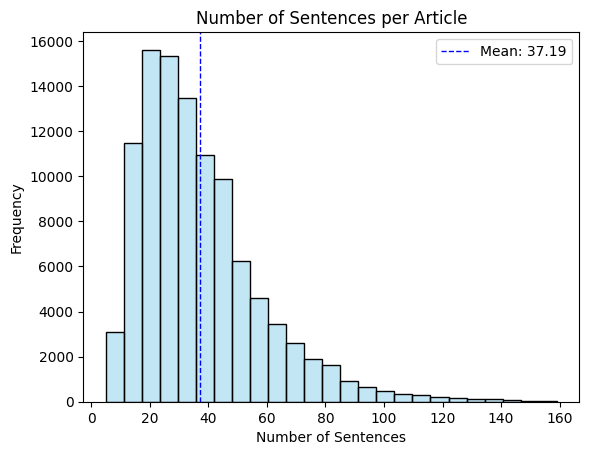

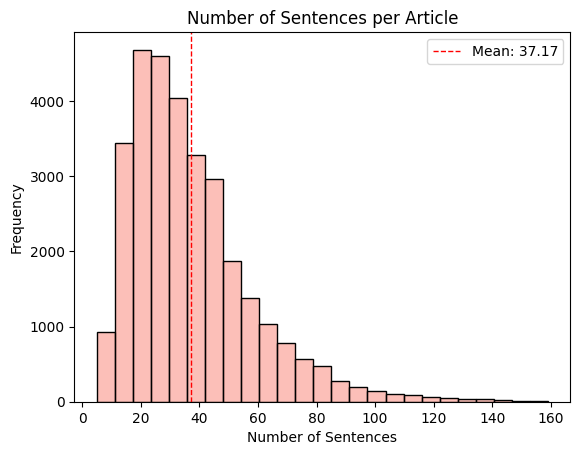

In [48]:
# Compute the mean number of sentences per article for both the full dataset and the sample
mean_sentences = df['num_sentences'].mean()
mean_sentences_sample = sample_df['num_sentences'].mean()

# Plot 1: Number of Sentences per Article (full dataset and sample)
sns.histplot(df[df['num_sentences'] < 160]['num_sentences'], kde = False, color = 'skyblue', alpha = 0.5, bins = 25)
plt.axvline(mean_sentences, color = 'blue', linestyle = 'dashed', linewidth = 1, label = f'Mean: {mean_sentences:.2f}')
plt.title('Number of Sentences per Article')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.histplot(sample_df[sample_df['num_sentences'] < 160]['num_sentences'], kde = False, color = 'salmon', alpha = 0.5, bins = 25)
plt.axvline(mean_sentences_sample, color = 'red', linestyle = 'dashed', linewidth = 1, label=f'Mean: {mean_sentences_sample:.2f}')
plt.title('Number of Sentences per Article')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()
plt.show()

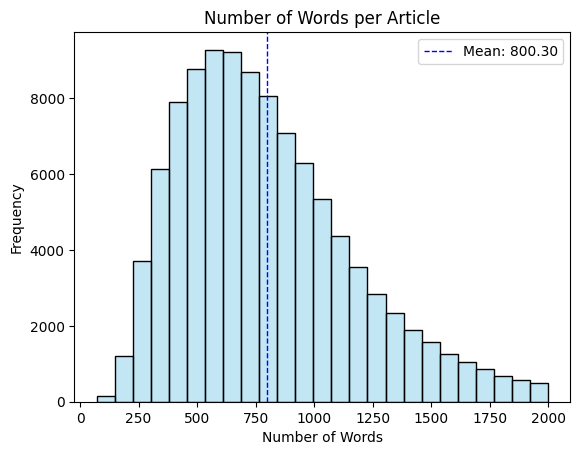

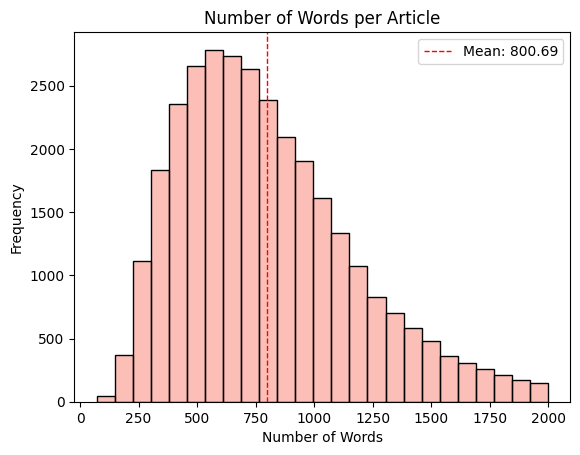

In [49]:
# Compute the mean number of words per article for both the full dataset and the sample
mean_words = df['num_words'].mean()
mean_words_sample = sample_df['num_words'].mean()

# Plot 2: Number of Words per Article (both full dataset and sample)
sns.histplot(df[df['num_words'] < 2000]['num_words'], kde = False, color = 'skyblue', alpha = 0.5, bins = 25)
plt.axvline(mean_words, color = 'blue', linestyle = 'dashed', linewidth = 1, label = f'Mean: {mean_words:.2f}')
plt.title('Number of Words per Article')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.histplot(sample_df[sample_df['num_words'] < 2000]['num_words'], kde = False, color = 'salmon', alpha = 0.5, bins = 25)
plt.axvline(mean_words_sample, color = 'red', linestyle = 'dashed', linewidth = 1, label=f'Mean: {mean_words_sample:.2f}')
plt.title('Number of Words per Article')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

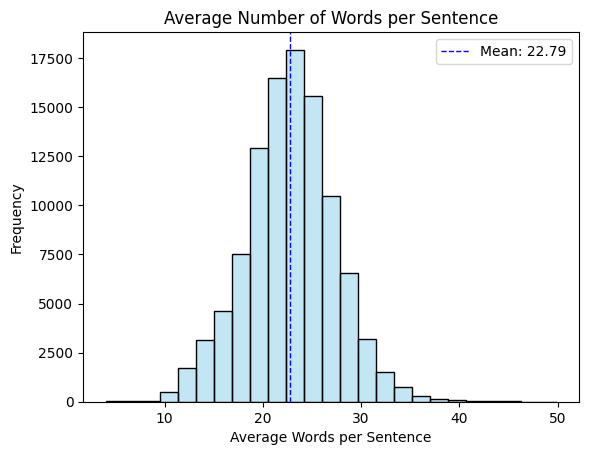

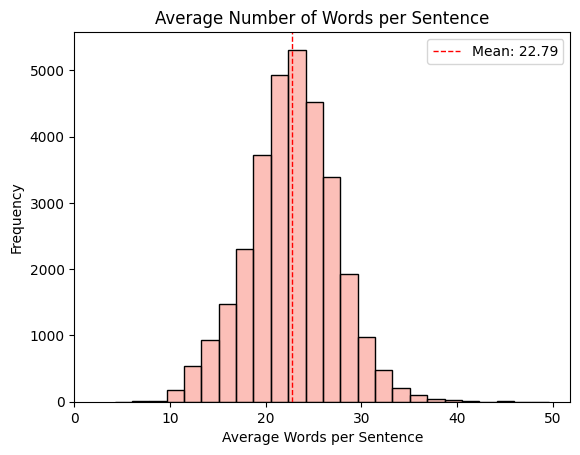

In [50]:
# Compute the mean average number of words per sentence for both the full dataset and the sample
mean_avg_words = df['avg_words_per_sentence'].mean()
mean_avg_words_sample = sample_df['avg_words_per_sentence'].mean()

# Plot 3: Average Number of Words per Sentence (both full dataset and sample)
sns.histplot(df[df['avg_words_per_sentence'] < 50]['avg_words_per_sentence'] , kde = False, color = 'skyblue', alpha = 0.5, bins = 25)
plt.axvline(mean_avg_words, color = 'blue', linestyle = 'dashed', linewidth = 1, label = f'Mean: {mean_avg_words:.2f}')
plt.title('Average Number of Words per Sentence')
plt.xlabel('Average Words per Sentence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.histplot(sample_df[sample_df['avg_words_per_sentence'] < 50]['avg_words_per_sentence'], kde = False, color = 'salmon', alpha = 0.5, bins = 25)
plt.axvline(mean_avg_words_sample, color = 'red', linestyle = 'dashed', linewidth = 1, label=f'Mean: {mean_avg_words_sample:.2f}')
plt.xlim(left = 0)
plt.title('Average Number of Words per Sentence')
plt.xlabel('Average Words per Sentence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

As we can see, the above histograms demonstrate that the sample’s distributions align closely with those of the full dataset. This ensures that the conclusions drawn from the sample are applicable to the entire dataset.

# TextRank algorithm

## Text preprocessing

Text preprocessing is essential when working with text data, as it transforms raw text into a clean and structured format, enhancing the effectiveness of algorithms like TextRank. Proper preprocessing helps to eliminate noise, standardize the data, and improve the overall quality of the analysis. The preprocessing steps implemented in this project include lowercasing, stopwords removal, punctuation removal and stemming/lemmatization.

We report below the Python function, `preprocess_function`, created to implement these preprocessing steps.

In [21]:
# Initialize stemmer/lemmatizer and stopwords
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """
    Convert Treebank POS tags to WordNet POS tags.

     Parameters:
    - treebank_tag: str
        A POS tag from the Treebank format.
        
    Returns:
    - WordNet POS tag corresponding to the input POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_function(sentences, stemming = True):
    """
    Preprocess the list of sentences by tokenizing, removing punctuation,
    converting to lowercase, and applying either stemming or lemmatization.

    Parameters:
    - sentences: list of str
        List of sentences to preprocess.
    - stemming: bool, optional (default = True)
        If True, apply stemming; otherwise, apply lemmatization.
    
    Returns:
    - list of list of str
        Preprocessed sentences where each sentence is tokenized into words.
    """

    # Regular expression pattern to remove punctuation
    pattern = re.compile(r'[^\w\s]')
    # Initialization of the list that will contain the preprocessed sentences
    preprocessed_sentences = []

    for sent in sentences:
        # Tokenize the sentence into words
        words = nltk.word_tokenize(sent)
        # Remove punctuation, convert to lowercase, and filter out empty strings
        processed_words = [pattern.sub('', word).lower() for word in words if pattern.sub('', word).strip()]
        
        if stemming:
            # Apply stemming while removing stopwords
            preprocessed_sentences.append([
                stemmer.stem(word) 
                for word in processed_words 
                if word not in stop_words
            ])
        else:
            # Apply lemmatization with POS tagging while removing stopwords
            tagged_words = nltk.pos_tag(processed_words)
            preprocessed_sentences.append([
                lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                for word, tag in tagged_words
                if word not in stop_words
            ])

    return preprocessed_sentences

Before applying TextRank algorithm, we preprocess twice the articles in the `sample_df` DataFrame using first stemming and then lemmatization. We also compute the average preprocessing times to compare the two techniques.

In [22]:
# Initialize an array to store preprocessing times
preproc_times_stem = np.zeros(len_sample_df)
# Initialize a list to store preprocessed sentences for each article
preproc_sentences_list = []

# Iterate over each article in the sample_df DataFrame
for i in tqdm(range(len_sample_df)):
    
    sentences = sample_df.loc[i, 'article_sent']

    # Measure the time taken for preprocessing
    start_time = time.time()
    # Preprocess the sentences using stemming
    preproc_sentences = preprocess_function(sentences, stemming = True)
    preproc_times_stem[i] = time.time() - start_time
    
    # Append the preprocessed sentences to the list
    preproc_sentences_list.append(preproc_sentences)

# Assign the list of preprocessed sentences as a new column in the DataFrame
sample_df['preproc_stem'] = preproc_sentences_list

# Compute the average preprocessing time
mean_preproc_time_stem = np.mean(preproc_times_stem)
print(f"The average preprocessing time using stemming is {mean_preproc_time_stem:.4f} seconds.")

100%|██████████| 31108/31108 [06:30<00:00, 79.63it/s] 

The average preprocessing time using stemming is 0.0125 seconds.


In [53]:
# Initialize an array to store preprocessing times
preproc_times_lem = np.zeros(len_sample_df)
# Initialize a list to store preprocessed sentences for each article
preproc_sentences_list = []

# Iterate over each article in the sample_df DataFrame
for i in tqdm(range(len_sample_df)):
    
    sentences = sample_df.loc[i, 'article_sent']

    # Measure the time taken for preprocessing
    start_time = time.time()
    # Preprocess the sentences using lemmatization
    preproc_sentences = preprocess_function(sentences, stemming = False)
    preproc_times_lem[i] = time.time() - start_time
    
    # Append the preprocessed sentences to the list
    preproc_sentences_list.append(preproc_sentences)

# Assign the list of preprocessed sentences as a new column in the DataFrame
sample_df['preproc_lem'] = preproc_sentences_list

# Compute the average preprocessing time
mean_preproc_time_lem = np.mean(preproc_times_lem)
print(f"The average preprocessing time using lemmatization is {mean_preproc_time_lem:.4f} seconds.")

100%|██████████| 31108/31108 [31:47<00:00, 16.31it/s]

The average preprocessing time using lemmatization is 0.0610 seconds.


As expected, the average execution time for text preprocessing is significantly lower for stemming ($0.0125s$) compared to lemmatization ($0.0610s$).

## TextRank implementation

We implement the TextRank algorithm using two functions: the primary function, `textrank`, performs the TextRank algorithm, ranking sentences based on similarity; the helper function, `sentence_similarity`, calculates the normalized word overlap similarity between any two sentences.

In [23]:
def sentence_similarity(words1, words2):
    """
    Calculate similarity between two sentences based on word overlap.

    Parameters:
    - words1: list of str
        List of words in the first sentence.
    - words2: list of str
        List of words in the second sentence.
        
    Returns:
    - float
        Normalized word overlap similarity score between the two sentences.
    """
    # Create word frequency counters for both sentences
    counter1 = Counter(words1)
    counter2 = Counter(words2)
    # Calculate the number of common words
    common_words = sum((counter1 & counter2).values())

    if common_words == 0:
        return 0.0

    # Calculate the denominator for similarity score
    den = math.log(len(words1)) + math.log(len(words2))

    if np.isclose(den, 0.):
        # This should only happen when words1 and words2 only have a single word.
        # Thus, num can only be 0 or 1.
        return float(common_words)
    else:
        return common_words / den

def textrank(sentences_as_words, damping, threshold, max_iter = float('inf')):
    """
    Apply the TextRank algorithm using adjacency matrices to rank sentences based on their similarity.

    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.
    - damping: float
        The damping factor (typically set between 0.85 and 0.95), controlling the probability of randomly jumping to another sentence.
    - threshold: float
        Threshold value for convergence.
    - max_iter: int, optional
        Maximum number of iterations for the power method. Default is float('inf') (no limit).
    
    Returns:
    - list of tuple
        A ranked list of sentences based on their TextRank score, where each tuple contains
        the index of the sentence and its corresponding rank score.
    - int
        The number of iterations it takes for the power method to converge within the given threshold.
    """
    
    # Compute the number of sentences
    n_sentences = len(sentences_as_words)

    # Initialize the adjacency matrix
    similarity_matrix = np.zeros((n_sentences, n_sentences))

    # Fill the adjacency matrix with similarity scores
    for i, words_i in enumerate(sentences_as_words):
        for j in range(i, n_sentences):
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # The matrix is symmetric, so similarity_matrix[i, j] is equal to similarity_matrix[j, i]
            similarity_matrix[i, j] = similarity_ij
            similarity_matrix[j, i] = similarity_ij
       
    # Normalize similarity_matrix to make it a stochastic matrix
    row_sums = similarity_matrix.sum(axis = 1) + 1e-8  # Add a constant to prevent division by 0
    similarity_matrix = np.divide(similarity_matrix, row_sums[:, np.newaxis])
    # Apply the damping factor to get the transition matrix
    similarity_matrix = np.full((n_sentences, n_sentences), (1. - damping) / n_sentences) + damping * similarity_matrix
    
    # Apply the power method
    transposed_matrix = similarity_matrix.T
    # Initialize the PageRank vector (all sentences have equal probability initially)
    p_vector = np.ones(n_sentences) / n_sentences
    # Initialize the convergence value
    lambda_val = float('inf')

    iter_count = 0
    while lambda_val > threshold and iter_count < max_iter:
        next_p = np.dot(transposed_matrix, p_vector)
        lambda_val = np.linalg.norm(next_p - p_vector)
        # Update the PageRank vector for the next iteration
        p_vector = next_p
        iter_count += 1

    # Rank the sentences based on their PageRank scores
    ranked_sentences = sorted(enumerate(p_vector), key = lambda x: x[1], reverse = True)

    return ranked_sentences, iter_count

$\textit{Remark:}$ Notice that we chose not to include the preprocessing step within the `textrank` function because this function is called multiple times in our simulations, and repeating preprocessing each time would significantly slow down execution.

Below is the `textrank_metrics` function, which is used to apply Textrank on a whole dataset of texts and evaluate its performance. The performance metrics include: mean execution time, mean ROUGE-1, ROUGE-2 and ROUGE-L scores, and eventually iteration-related metrics (mean, median, maximum and percentiles).

In [24]:
def textrank_metrics(df, num_sent_summary, damping, thresh_conv, max_iter = float('inf'), stemming = True, iter_metrics = False):
   '''
   This function applies the Textrank algorithm on a dataset of articles and evaluates its performance, including execution times and ROUGE scores.

   Parameters:
   - df: pandas.DataFrame 
      DataFrame containing articles and reference summaries. Must include preprocessed sentences.
   - num_sent_summary: int
      Number of sentences to include in the generated summary.
   - damping: float
      Damping factor for the Textrank algorithm.
   - thresh_conv: float
      Convergence threshold for Textrank.
   - max_iter: int, optional
      Maximum number of iterations for Textrank. Default is float('inf') (no limit).
   - stemming: bool, optional
      Flag to choose between stemming and lemmatization. Default is True (stemming).
   - iter_metrics: bool, optional
      If True, computes and includes iteration-related metrics (mean, median, maximum, and percentiles) in the results.

   Returns:
   - results_metrics: pandas.DataFrame
      Pandas DataFrame with aggregated metrics including mean execution time, ROUGE scores and eventually iteration-related metrics.
   '''

   len_df = len(df)

   # Initialize numpy arrays to store metrics for each article
   num_iterations = np.zeros(len_df)  # Number of iterations needed for convergence
   textrank_times = np.zeros(len_df)  # Textrank execution times
   rouge_1 = np.zeros(len_df)  # ROUGE-1 F1 scores
   rouge_2 = np.zeros(len_df)  # ROUGE-2 F1 scores
   rouge_l = np.zeros(len_df)  # ROUGE-L F1 scores

   # Initialize the ROUGE metric for evaluating summaries
   rouge = Rouge()

   # Iterate over each article in the df DataFrame
   for i, row in tqdm(df.iterrows(), total = len_df):
      
      # Extract article sentences and reference summary
      sentences = row['article_sent']
      reference_summary = row['highlights']
      # Use preprocessed sentences based on the stemming flag
      preprocessed_sentences = row['preproc_stem'] if stemming else row['preproc_lem']

      # Start measuring execution time
      start_time = time.time()
      # Apply Textrank and store the number of iterations
      ranked_sentences, num_iter = textrank(preprocessed_sentences, damping, thresh_conv, max_iter)
      # Measure execution time and store the results
      textrank_times[i] = time.time() - start_time
      num_iterations[i] = num_iter

      # Generate the summary based on the top-ranked sentences
      summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
      candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])

      # Calculate ROUGE scores for the generated summary
      rouge_scores = rouge.get_scores(candidate_summary, reference_summary)[0]
      rouge_1[i] = rouge_scores['rouge-1']['f']
      rouge_2[i] = rouge_scores['rouge-2']['f']
      rouge_l[i] = rouge_scores['rouge-l']['f']

   # Aggregate results across all articles
   results_metrics = {
      'mean_exec_time': np.mean(textrank_times),  # Mean execution time of Textrank
      'rouge_1_mean': np.mean(rouge_1),  # Mean ROUGE-1 F1 score
      'rouge_2_mean': np.mean(rouge_2),  # Mean ROUGE-2 F1 score
      'rouge_l_mean': np.mean(rouge_l)  # Mean ROUGE-L F1 score
   }

   # If the iteration metrics are included
   if iter_metrics:
      # Calculate 90,95,99th percentiles of num_iterations
      percentiles = np.percentile(num_iterations, [90, 95, 99])

      # Add to results_metrics the metrics related to the iterations
      results_metrics.update({
         'mean_n_iter': np.mean(num_iterations),
         'median_n_iter': np.median(num_iterations),
         'max_n_iter': np.max(num_iterations),
         '90th_perc_n_iter': percentiles[0],
         '95th_perc_n_iter': percentiles[1],
         '99th_perc_n_iter': percentiles[2]
      })
   
   results_metrics = pd.DataFrame({k: [round(v, 4)] for k, v in results_metrics.items()})
   
   return results_metrics     

## Parameter selection

We now tune the parameters of the TextRank algorithm to ensure optimal performance. Specifically, we optimize two key parameters: the convergence threshold and the maximum number of iterations for the power method. Additionally, we compare stemming and lemmatization as text preprocessing techniques to determine which provides a better trade-off between computational efficiency and output quality.

The damping factor for the power method is fixed at $0.85$, which is a common choice for this parameter, as suggested by the original PageRank algorithm. To tune these parameters and compare stemming vs. lemmatization, we repeatedly apply the TextRank algorithm to `sample_df`.
The process is divided into two steps: 
1) First, we optimize the convergence threshold and choose between stemming and lemmatization;
2) Then, we fine-tune the maximum number of iterations.

To optimize the convergence threshold and select between stemming and lemmatization, we apply to `sample_df` the TextRank algorithm for different values of the convergence threshold ($10^{-1}, 10^{-2}, 10^{-3}$ and $10^{-4}$), and analyze the following metrics: mean execution time per article, mean ROUGE-1, ROUGE-2, and ROUGE-L scores and statistics on the number of iterations required for convergence (mean, median, maximum, 90th, 95th, and 99th percentiles). This process is repeated twice, first with stemming and then with lemmatization applied during text preprocessing. Additionally, to ensure the algorithm’s convergence for all thresholds, the maximum number of iterations is set to $10,000$, as if there is no limit.

Stemming:

In [25]:
# Number of sentences to include in the summary, damping factor and max. number of iterations
num_sent_summary = 4
damping = 0.85
max_iter = 10000
# Define convergence thresholds to test
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]

# Iterate over each threshold and store the results in a DataFrame (stemming)
results_stem = pd.DataFrame()
for thresh_conv in thresholds:
    results_metrics = textrank_metrics(sample_df, num_sent_summary, damping, thresh_conv, max_iter, 
                                       stemming = True, iter_metrics = True)
    results_stem = pd.concat([results_stem, results_metrics], ignore_index = True)

results_stem

100%|██████████| 31108/31108 [10:55<00:00, 47.44it/s]


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean,mean_n_iter,median_n_iter,max_n_iter,90th_perc_n_iter,95th_perc_n_iter,99th_perc_n_iter
0,0.0151,0.2940,0.0986,0.2708,1.0001,1.0,2.0,1.0,1.0,1.0
1,0.0151,0.2943,0.0991,0.2713,2.4327,2.0,5.0,3.0,3.0,3.0
2,0.0152,0.2952,0.0999,0.2722,7.6881,7.0,109.0,8.0,8.0,50.0
3,0.0159,0.2954,0.1001,0.2724,75.0784,13.0,544.0,375.0,490.0,521.0


Lemmatization:

In [57]:
# Number of sentences to include in the summary, damping factor and max. number of iterations
num_sent_summary = 4
damping = 0.85
max_iter = 10000
# Define convergence thresholds to test
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]

# Iterate over each threshold and store the results in a DataFrame (lemmatization)
results_lem = pd.DataFrame()
for thresh_conv in thresholds:
    results_metrics = textrank_metrics(sample_df, num_sent_summary, damping, thresh_conv, max_iter, 
                                       stemming = False, iter_metrics = True)
    results_lem = pd.concat([results_lem, results_metrics], ignore_index = True)

results_lem

100%|██████████| 31108/31108 [10:42<00:00, 48.42it/s]


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean,mean_n_iter,median_n_iter,max_n_iter,90th_perc_n_iter,95th_perc_n_iter,99th_perc_n_iter
0,0.0148,0.2932,0.0981,0.2700,1.0001,1.0,2.0,1.0,1.00,1.0
1,0.0147,0.2934,0.0985,0.2704,2.4205,2.0,5.0,3.0,3.00,3.0
2,0.0148,0.2941,0.0992,0.2711,7.6796,7.0,109.0,8.0,8.00,50.0
3,0.0155,0.2941,0.0993,0.2712,75.0567,13.0,544.0,375.0,490.65,521.0


As we can see from the above tables:
- Both stemming and lemmatization yield comparable ROUGE scores, with stemming having a slight edge at all thresholds. Moreover, for both techniques the ROUGE scores increase slightly with a lower convergence threshold.
- In terms of iterations and convergence speed, both methods show similar trends. As expected, the execution time and the number of iterations grow as the convergence threshold decreases.

Although the performance metrics for stemming and lemmatization are almost identical, we select stemming as preprocessing method due to its superior efficiency: we obtained that the average execution time for text preprocessing was significantly lower for stemming ($0.0125s$) compared to lemmatization ($0.0610s$). The slight improvement in ROUGE scores with stemming further supports this decision.

As for the convergence threshold, we choose $10^{-3}$ as the optimal value. Indeed, it provides a good trade-off between computational efficiency and performance, with a slight increase in ROUGE scores compared to $10^{-2}$ and $10^{-1}$. Although $10^{-4}$ gives marginally higher ROUGE scores, it significantly increases the number of iterations, making it impractical for large datasets. Moreover, $10^{-3}$ offers flexibility for more complex articles compared to higher thresholds like $10^{-1}$ and $10^{-2}$, which often converge prematurely (from $1$ to $3$ iterations).

Using stemming and a convergence threshold of $10^{-3}$, we now tune the maximum number of iterations for the power method. We test three values: $7$, $8$, and $50$, corresponding to the mean, the 95th percentile (=90th percentile) and the 99th percentile of the number of iterations observed in the previous experiments.\
For each value we collect the mean execution time per article and the mean ROUGE scores.

In [58]:
# Number of sentences to include in the summary, damping factor and convergence threshold
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
# Define max number of iterations to test
col_names_iter = ['mean_n_iter', 'median_n_iter', '90th_perc_n_iter', '95th_perc_n_iter', '99th_perc_n_iter']
max_iter_values = sorted(set(results_stem.loc[2][col_names_iter].round()))

# Iterate over each element in max_iter_values and store the results in a DataFrame
results_max = pd.DataFrame()
for max_iter in max_iter_values:
    results_metrics = textrank_metrics(sample_df, num_sent_summary, damping, thresh_conv, max_iter, 
                                       stemming = True, iter_metrics = False)
    results_max = pd.concat([results_max, results_metrics], ignore_index = True)

results_max.insert(0, 'max_n_iter', max_iter_values)
results_max

100%|██████████| 31108/31108 [10:24<00:00, 49.85it/s]


,max_n_iter,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,7.0,0.0148,0.2951,0.0999,0.2722
1,8.0,0.0147,0.2952,0.0999,0.2722
2,50.0,0.0148,0.2952,0.0999,0.2722


As we can see, all three configurations yield nearly identical ROUGE scores. However, $8$ iterations provide the fastest execution time. Choosing $8$ strikes a balance between being too conservative (like $7$) and unnecessarily extending the runtime (like $50$), ensuring quick convergence without sacrificing the summaries' quality.

## Performance evaluation

To evaluate the performance of the TextRank algorithm, we apply it to the entire dataset, `df`, using the optimized parameters determined in the tuning phase. Specifically, we set the convergence threshold to $10^{-3}$, the maximum number of iterations to $8$, the damping factor to $0.85$ and we employ stemming during text preprocessing. We then collect the following metrics: mean execution time and mean ROUGE scores.

First, we preprocess the articles using stemming.

In [27]:
# Convert the already preprocessed indices to a set for faster lookups
preproc_indices_set = set(sample_df['index'].tolist())

# Set 'index' as the index of sample_df for faster row access
sample_df.set_index('index', inplace = True)

# Initialize a list to store preprocessed sentences for each article
preproc_sentences_list = [None] * len_df

# Fill the preproc_sentences_list with already preprocessed articles
for idx in preproc_indices_set:
    preproc_sentences_list[idx] = sample_df.loc[idx, 'preproc_stem']

# Iterate over each article in the df DataFrame
for i in tqdm(range(len_df)):
    
    # Skip the article if it's already been preprocessed
    if i in preproc_indices_set:
        continue 
    
    sentences = df.loc[i, 'article_sent']

    # Preprocess the sentences using stemming
    preproc_sentences = preprocess_function(sentences, stemming = True)
    
    # Store the preprocessed sentences in the corresponding position in the list
    preproc_sentences_list[i] = preproc_sentences

# Assign the list of preprocessed sentences as a new column in the DataFrame
df['preproc_stem'] = preproc_sentences_list
sample_df = sample_df.reset_index()

100%|██████████| 103700/103700 [15:09<00:00, 114.02it/s]


Then, we apply TextRank on `df` and collect the performance metrics.

In [28]:
# Initialize the selected parameters
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
max_iter = 8

# Apply Textrank to the whole dataset and store the performance metrics
results_textrank_1 = textrank_metrics(df, num_sent_summary, damping, thresh_conv, max_iter, stemming = True, iter_metrics = False)

results_textrank_1

100%|██████████| 103700/103700 [35:41<00:00, 48.43it/s] 


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,0.0153,0.2952,0.0998,0.2721


### Baselines

ROUGE metrics provide a quantitative measure of the quality of text summarization, but the raw scores alone are not sufficient to properly judge the performance. In text summarization, especially with extractive algorithms like TextRank, very high ROUGE scores are rarely achievable since this would require the generated summary to be nearly identical to the reference summary. Therfore, to assess the quality of our results, rather than evaluating how close the ROUGE scores are to $1$, we compare them to two baselines:
1) $\textit{Random baseline}$ (Lower bound): For each article, this baseline generates a summary by randomly selecting four sentences from the article. The mean ROUGE scores are then computed across all articles. This represents a lower bound for comparison, indicating the expected performance of an entirely random approach.
2) $\textit{Greedy oracle baseline}$ (Upper bound): For each article, the oracle baseline evaluates all possible combinations of four sentences to find the combination that maximizes the ROUGE scores compared to the reference summary. Given the large amount of data we have (over $100,000$ articles), this approach is infeasible, so we use a greedy approximation. Specifically:
   - For each sentence in the article, the mean of the three ROUGE scores between the sentence and the reference summary is computed. Then, the four sentences providing the highest scores are selected to form the summary.
   - For practical reasons, we limit the candidate sentences to the first half of each article. This is justified by considering that, in general, important information is presented at the beginning of an article.

The functions below implement these two approaches.

In [61]:
# Initialize ROUGE object once to avoid re-instantiating it in each function call
rouge = Rouge()

def compute_rouge(candidate_summary, reference_summary):
    '''
    This function computes the ROUGE scores (ROUGE-1, ROUGE-2, and ROUGE-L) between a candidate summary and the reference summary.

    Parameters:
    - candidate_summary: str
       String containing the generated summary.
    - reference_summary: str
       String containing the reference summary.

    Returns:
    - tuple: (rouge1_f, rouge2_f, rougel_f)
       Return a tuple containing the F1-scores for the three ROUGE metrics.
    '''
    scores = rouge.get_scores(candidate_summary, reference_summary)[0]
    
    rouge1_f = scores['rouge-1']['f']
    rouge2_f = scores['rouge-2']['f']
    rougel_f = scores['rouge-l']['f']
    
    return rouge1_f, rouge2_f, rougel_f

def greedy_oracle_summary(sentences, reference_summary, num_sentences = 4):
    '''
    This function generates a summary by greedily selecting the top sentences that maximize the ROUGE score in relation to the reference summary.
    It calculates the ROUGE score for each sentence in the first half of the article and selects the best `num_sentences` to form the summary.

    Parameters:
    - sentences: List of str
       Each string is a sentence from the original article;
    - reference_summary: str
       String containing the reference summary to compare the candidate sentences with.
    - num_sentences: int
       The number of sentences to be included in the final summary. Default is 4.

    Returns:
    - String: A summary consisting of the selected sentences, joined together by periods (".").
    '''
    
    # List to store sentences and their corresponding ROUGE scores
    sentence_rouge_scores = []

    # Limit to the first half of the sentences or `num_sentences` to reduce computation
    limit = max(num_sentences, len(sentences) // 2)

    # Compute the ROUGE scores for the first 'limit' number of sentences
    for i in range(limit):
    
            sentence = sentences[i]
            
            # Skip sentences with fewer than 2 words, as they are not useful for summarization
            if len(sentence.split()) <= 1:
                continue
            
            # Calculate ROUGE scores between the candidate sentence and the reference summary
            rouge_1, rouge_2, rouge_l = compute_rouge(sentence, reference_summary)
            
            # Compute the average of the three ROUGE scores
            rouge_score = (rouge_1 + rouge_2 + rouge_l) / 3
            
            # Append the sentence index and its average ROUGE score to the list
            sentence_rouge_scores.append((i, rouge_score))
    
    # Sort sentences by their ROUGE score in descending order
    ranked_sentences = sorted(sentence_rouge_scores, key = lambda x: x[1], reverse = True)
    # Get the indices of the top `num_sent_summary` sentences
    summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
    # Join the sentences using the selected indices (sorted) to form the final summary
    candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])

    return candidate_summary   

def get_rouge_baselines(df, num_sent_summary = 4, random_bl = True):
    '''
    This function calculates ROUGE baseline scores for a dataset of articles. It either computes a random summary baseline or a greedy oracle summary baseline, depending on the value of `random_bl`.

    Parameters:
    - df: DataFrame
        The dataset containing the articles. Each row should have 'highlights' (reference summary) and 'article_sent' (list of sentences).
    - num_sent_summary: int
        The number of sentences to include in the summary. Default is 4.
    - random_bl: bool
        If True, the function generates a random summary baseline. If False, it uses the greedy oracle baseline.

    Returns:
    - baseline_rouge_1: float
        The average ROUGE-1 F1 score over the dataset.
    - baseline_rouge_2: float
        The average ROUGE-2 F1 score over the dataset.
    - baseline_rouge_l: float
        The average ROUGE-L F1 score over the dataset.
    '''

    len_df = len(df)

    # Initialize numpy arrays to store ROUGE-1, ROUGE-2, and ROUGE-L scores for each article
    rouge_1 = np.zeros(len_df)
    rouge_2 = np.zeros(len_df)
    rouge_l = np.zeros(len_df)

    # Set a random seed for reproducibility (if using random baseline)
    if random_bl:
        random.seed(1)

    # Loop through each article in the dataset
    for i in tqdm(range(len_df)):
        # Extract reference summary and sentences from the article
        reference_summary = df.loc[i, 'highlights']
        sentences = df.loc[i, 'article_sent']
        # If random_bl = True, generate a random summary, else the greedy oracle summary
        if random_bl:
            # Randomly sample 'num_sent_summary' sentences from the list of sentences and then join them into a single string
            candidate_summary = ' '.join(random.sample(sentences, num_sent_summary))
        else:
            candidate_summary = greedy_oracle_summary(sentences, reference_summary, num_sent_summary)
        
        # Compute and store ROUGE-1, ROUGE-2, and ROUGE-L scores for the generated summary
        rouge_1[i], rouge_2[i], rouge_l[i] = compute_rouge(candidate_summary, reference_summary)

    # Calculate the average ROUGE-1, ROUGE-2, and ROUGE-L scores
    baseline_rouge_1 = np.mean(rouge_1)
    baseline_rouge_2 = np.mean(rouge_2)
    baseline_rouge_l = np.mean(rouge_l)
    
    return baseline_rouge_1, baseline_rouge_2, baseline_rouge_l

We now compute the two baselines and print the results.

In [114]:
# Random baseline
baseline_random_1, baseline_random_2, baseline_random_l = get_rouge_baselines(df, num_sent_summary = 4, random_bl = True)

print(f"\nThe ROUGE scores for the random baseline are: ROUGE-1: {baseline_random_1:.4f} , ROUGE-2: {baseline_random_2:.4f}, ROUGE-L: {baseline_random_l:.4f}")

100%|██████████| 103700/103700 [07:40<00:00, 225.31it/s]


The ROUGE scores for the random baseline are: ROUGE-1: 0.2374 , ROUGE-2: 0.0626, ROUGE-L: 0.2184


In [63]:
# Greedy oracle baseline
baseline_oracle_1, baseline_oracle_2, baseline_oracle_l = get_rouge_baselines(df, num_sent_summary = 4, random_bl = False)

print(f"\nThe ROUGE scores for the greedy oracle baseline are: ROUGE-1: {baseline_oracle_1:.4f} , ROUGE-2: {baseline_oracle_2:.4f}, ROUGE-L: {baseline_oracle_l:.4f}")

100%|██████████| 103700/103700 [40:51<00:00, 42.30it/s]   



The ROUGE scores for the greedy oracle baseline are: ROUGE-1: 0.4222 , ROUGE-2: 0.1977, ROUGE-L: 0.3983


# Improvements

## 1) Sparsifying the graphs

The first optimization we introduce involves sparsifying the similarity graphs in order to reduce the memory usage of TextRank. In the standard TextRank algorithm the similarity graph is represented by a dense adjacency matrix, where each element corresponds to the similarity score between two sentences. While this representation is justified in most cases because similarity graphs are relatively dense, it is possible that certain low similarities do not significantly impact the ranking process. Hence, sparsifying the graphs by introducing a threshold can help reduce memory usage without substantially affecting the algorithm's output quality.

In order to do so, we introduce the threshold $\textit{threshold\_sim}$. Any similarity score below this threshold is set to 0, effectively removing the corresponding edge from the graph. This sparsification reduces the number of non-zero entries in the adjacency matrix, enabling the use of sparse matrix representations, which are significantly more memory-efficient than dense matrices.

### Selecting $\textit{threshold\_sim}$

To determine for our dataset a suitable value for $\textit{threshold\_sim}$, we analyze the mean density of the adjacency matrices for various thresholds using the `sample_df` DataFrame. We test a range of values from $0$ to $0.5$ with a step size of $0.05$, and compute for each the mean density. We plot the results below.

In [64]:
def create_similarity_matrix(sentences_as_words):
    """
    Creates a similarity matrix for a set of sentences, where each element represents the similarity score between two sentences.

    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.

    Returns:
    - similarity_matrix: np.ndarray 
        A 2D numpy array of size n_sentences x n_sentences, where each element [i, j] represents the similarity between sentence i and sentence j.
    """

    n_sentences = len(sentences_as_words)
    
    # Initialize a similarity matrix with zeros
    similarity_matrix = np.zeros((n_sentences, n_sentences))

    # Fill the similarity matrix with similarity scores
    for i, words_i in enumerate(sentences_as_words):
        for j in range(i, n_sentences):
            # Calculate the similarity between sentence i and sentence j
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # The matrix is symmetric, so similarity_matrix[i, j] is equal to similarity_matrix[j, i]
            similarity_matrix[i, j] = similarity_ij
            similarity_matrix[j, i] = similarity_ij
       
    return similarity_matrix

In [113]:
# Define thresholds ranging from 0 to 0.5 with 11 equally spaced values
thresholds = np.linspace(0, 0.5, num = 11)

# Initialize a matrix to store the density values of the similarity matrices for each article 
# at each threshold. Rows correspond to different thresholds, columns to different articles
density_matrix = np.zeros((len(thresholds), len_sample_df))

for i in tqdm(range(len_sample_df)):

    # Take the already preprocessed article from the sample_df DataFrame
    preprocessed_sentences = sample_df.loc[i]['preproc_stem']

    # Compute the similarity matrix
    similarity_matrix = create_similarity_matrix(preprocessed_sentences)
    similarity_matrix_size = similarity_matrix.size

    for j, thresh in enumerate(thresholds):
        # Create a boolean mask where each element indicates whether the similarity value is above the threshold
        threshold_mask = similarity_matrix > thresh
        # Calculate the density by summing the number of True values in the mask and
        # dividing by the total size of the similarity matrix
        density_matrix[j, i] = np.sum(threshold_mask) / similarity_matrix_size

# Compute the mean density across all articles for each threshold
mean_density = np.mean(density_matrix, axis = 1)

100%|██████████| 31108/31108 [08:46<00:00, 59.05it/s] 


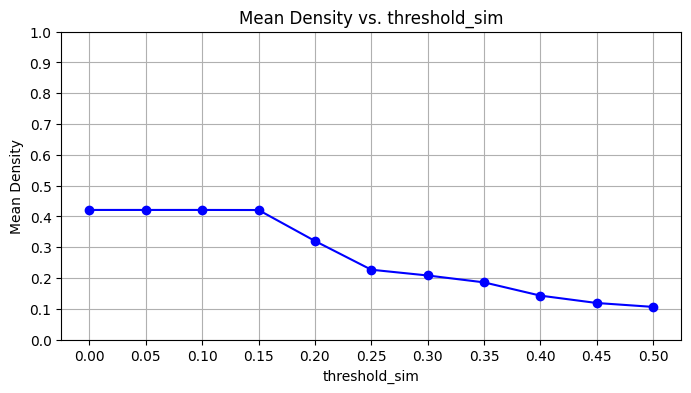

In [66]:
# Plot: Mean density vs threshold_sim
plt.figure(figsize = (8, 4))
plt.plot(thresholds, mean_density, marker = 'o', linestyle = '-', color = 'b')
plt.title('Mean Density vs. threshold_sim')
plt.xlabel('threshold_sim')
plt.ylabel('Mean Density')
plt.grid(True)
plt.xticks(np.linspace(0, 0.5, num = 11))
plt.yticks(np.linspace(0, 1, num = 11))
plt.show()

As we can see from the above line plot:
- When $\textit{threshold\_sim}=0$ (which corresponds to the standard case), the mean density is a bit higher than $0.4$, indicating that the graphs are relatively dense.
- As $\textit{threshold\_sim}$ increases, the mean density decreases, reaching approximately $0.1$ when $\textit{threshold\_sim}=0.5$.

Based on this, we choose a threshold of $0.35$. At this value, the mean density is approximately $0.19$, representing a good balance between sparsity and retaining meaningful connections. Indeed, if we set $\textit{threshold\_sim}$ too high we could risk losing important edges and make the algorithm's performance worse.

Additionally, we plot below the distribution of the density of adjacency matrices when $\textit{threshold\_sim}=0.35$. As we can see, most graphs are sparsified to densities approximately between $0$ and $0.25$, supporting our choice.

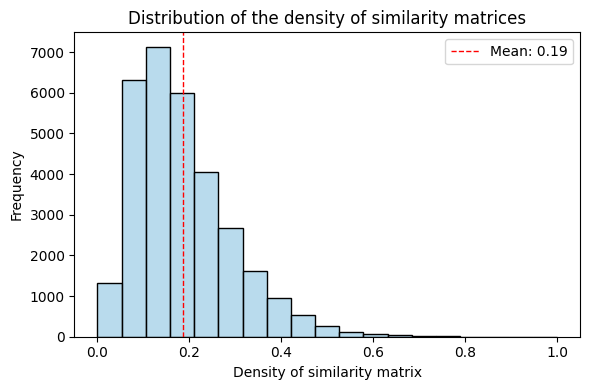

In [67]:
# Histogram: Density of similarity matrices where similarities below 0.35 are set to 0
plt.figure(figsize = (6, 4))
sns.histplot(density_matrix[7], bins = np.linspace(0, 1, num = 20), kde = False, color = '#A2CFE8')
plt.axvline(mean_density[7], color = 'r', linestyle = 'dashed', linewidth = 1, label = f'Mean: {mean_density[7]:.2f}')
plt.xlabel('Density of similarity matrix')
plt.ylabel('Frequency')
plt.title('Distribution of the density of similarity matrices')
plt.legend()

plt.tight_layout()
plt.show()

### Implementation and application

Below is the updated Python implementation of the TextRank algorithm with sparsification, `textrank_sparse`.

In [68]:
def textrank_sparse(sentences_as_words, damping, threshold_conv, threshold_sim, max_iter = float('inf')):
    """
    Apply the TextRank algorithm using sparse matrices to rank sentences based on their similarity.

    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.
    - damping: float
        The damping factor (typically between 0.85 and 0.95), controlling the probability of randomly jumping to another sentence.
    - threshold_conv: float
        Threshold value for convergence in the power method.
    - threshold_sim: float
        Similarity threshold to consider an edge between two sentences.
    - max_iter: int, optional
        Maximum number of iterations for the power method. Default is float('inf') (no limit).
    
    Returns:
    - list of tuple
        A ranked list of sentences based on their TextRank score, where each tuple contains
        the index of the sentence and its corresponding rank score.
    """
    
    # Compute the number of sentences
    n_sentences = len(sentences_as_words)
    
    # Initialize a sparse matrix using LIL format
    sparse_sim_matrix = lil_matrix((n_sentences, n_sentences))

    # Construct the sparse adjacency matrix based on sentence similarity
    for i, words_i in enumerate(sentences_as_words):
        for j in range(i, n_sentences):
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # Only consider similarities above threshold_sim
            if similarity_ij > threshold_sim: 
                sparse_sim_matrix[i, j] = similarity_ij
                sparse_sim_matrix[j, i] = similarity_ij
    
    # Convert to CSR format for efficient arithmetic operations
    sparse_sim_matrix = sparse_sim_matrix.tocsr()

    # Normalize the sparse adjacency matrix to make it stochastic
    row_sums = np.array(sparse_sim_matrix.sum(axis = 1)).flatten() + 1e-8
    sparse_sim_matrix = sparse_sim_matrix.multiply(1 / row_sums[:, np.newaxis])

    # Apply the power method
    transposed_matrix = sparse_sim_matrix.T   
    # Initialize the PageRank vector (all sentences have equal probability initially)
    p_vector = np.ones(n_sentences) / n_sentences
    # Random jump value (applied dynamically during each iteration)
    random_jump_value = (1.0 - damping) / n_sentences
    # Initialize the convergence value
    lambda_val = float('inf')

    iter_count = 0
    while lambda_val > threshold_conv and iter_count < max_iter:
        next_p = transposed_matrix.dot(p_vector)
        # Apply the random jump as part of the iteration
        next_p = damping * next_p + random_jump_value
        lambda_val = np.linalg.norm(next_p - p_vector)
        # Update the PageRank vector for the next iteration
        p_vector = next_p
        iter_count += 1

    # Rank the sentences based on their PageRank scores
    ranked_sentences = sorted(enumerate(p_vector), key = lambda x: x[1], reverse = True)

    return ranked_sentences

We also update the `textrank_metrics` function into `textrank_metrics_sparse`. This function applies to a dataset of texts the TextRank algorithm with sparsification and evaluates its performance. The performance metrics include: mean execution time and mean ROUGE-1, ROUGE-2, and ROUGE-L scores. Notice that we are no longer interested in the iteration-related metrics, since from now on we fix the maximum number of iterations to $8$, in order to make the results comparable with the ones obtained when we applied the standard TextRank algorithm. 

In [69]:
def textrank_metrics_sparse(df, num_sent_summary, damping, thresh_conv, thresh_sim, max_iter = float('inf'), stemming = True):
   '''
   This function applies the Textrank algorithm (with sparse adjacency matrices) on a dataset of articles and evaluates its performance, including execution times and ROUGE scores.

   Parameters:
   - df: pandas.DataFrame 
      DataFrame containing articles and reference summaries. Must include preprocessed sentences.
   - num_sent_summary: int
      Number of sentences to include in the generated summary.
   - damping: float
      Damping factor for the Textrank algorithm.
   - thresh_conv: float
      Convergence threshold for Textrank.
   - thresh_sim: float
      Similarity threshold to consider an edge between two sentences.
   - max_iter: int, optional
      Maximum number of iterations for Textrank. Default is float('inf') (no limit).
   - stemming: bool, optional
      Flag to choose between stemming and lemmatization. Default is True (stemming).

   Returns:
   - results_metrics: pandas.DataFrame
      Pandas DataFrame with aggregated metrics including mean execution times and ROUGE scores.
   '''

   len_df = len(df)

   # Initialize numpy arrays to store metrics for each article
   textrank_times = np.zeros(len_df)  # Textrank execution times
   rouge_1 = np.zeros(len_df)  # ROUGE-1 F1 scores
   rouge_2 = np.zeros(len_df)  # ROUGE-2 F1 scores
   rouge_l = np.zeros(len_df)  # ROUGE-L F1 scores

   # Initialize the ROUGE metric for evaluating summaries
   rouge = Rouge()

   # Iterate over each article in the DataFrame
   for i, row in tqdm(df.iterrows(), total = len_df):
      
      # Extract article sentences and reference summary
      sentences = row['article_sent']
      reference_summary = row['highlights']
      # Use preprocessed sentences based on the stemming flag
      preprocessed_sentences = row['preproc_stem'] if stemming else row['preproc_lem']

      # Start measuring execution time
      start_time = time.time()
      # Apply Textrank (with sparsification)
      ranked_sentences = textrank_sparse(preprocessed_sentences, damping, thresh_conv, thresh_sim, max_iter)
      # Measure execution time and store the result
      textrank_times[i] = time.time() - start_time

      # Generate the summary based on the top-ranked sentences
      summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
      candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])

      # Calculate ROUGE scores for the generated summary
      rouge_scores = rouge.get_scores(candidate_summary, reference_summary)[0]
      rouge_1[i] = rouge_scores['rouge-1']['f']
      rouge_2[i] = rouge_scores['rouge-2']['f']
      rouge_l[i] = rouge_scores['rouge-l']['f']

   # Aggregate results across all articles
   results_metrics = {
      'mean_exec_time': np.mean(textrank_times),  # Mean execution time of Textrank
      'rouge_1_mean': np.mean(rouge_1),  # Mean ROUGE-1 F1 score
      'rouge_2_mean': np.mean(rouge_2),  # Mean ROUGE-2 F1 score
      'rouge_l_mean': np.mean(rouge_l)  # Mean ROUGE-L F1 score
   }

   results_metrics = pd.DataFrame({k: [round(v, 4)] for k, v in results_metrics.items()})
   
   return results_metrics

We now apply the `textrank_metrics_sparse` function to the dataset `df`. The parameters are kept consistent with those optimized for the standard TextRank: a convergence threshold of $10^{-3}$, a damping factor of $0.85$, and a maximum of $8$ iterations for the power method. Additionally, a sparsification threshold of $0.35$ is used.

In [70]:
# Initialize the optimized parameters
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.35
max_iter = 8

# Apply textrank_sparse to the whole dataset and store the performance metrics
results_textrank_2 = textrank_metrics_sparse(df, num_sent_summary, damping, thresh_conv, thresh_sim, max_iter, stemming = True)

results_textrank_2

100%|██████████| 103700/103700 [45:05<00:00, 38.34it/s]   


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,0.0164,0.2971,0.1005,0.2738


## 2) Limiting sentence similarity computations

The second optimization we introduce involves restricting sentence similarity computations to a fixed window size $\textit{w}$, to improve TextRank algorithm's efficiency. Specifically, we compute similarity scores only for pairs of sentences that are at most $\textit{w}$ positions apart. This restriction reduces the computational cost associated with constructing the adjacency matrix without significantly affecting the algorithm's performance. Importantly, we implement this optimization in conjunction with sparsification, ensuring that only meaningful similarities (above a given threshold) are retained.

The idea of limiting similarity computations to a fixed window size arises from the observation that sentence similarity decreases with distance. To verify this for our dataset, we analyze how the similarity scores between sentences change as a function of their positional distance in the text. Specifically, using the representative sample `sample_df`, we compute the mean similarity scores for sentences separated by increasing distances and plot the results.

In [71]:
def distance_vs_similarity_score(sentences_as_words):
    """
    Computes the similarity between all pairs of sentences and their respective distances within an article.
    
    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.

    Returns:
    - DataFrame: 
      A DataFrame where each row contains for each pair of sentences their distance and their similarity score.
    """
    n_sentences = len(sentences_as_words)
    data = []

    # Iterate over each pair of sentences
    for i, words_i in enumerate(sentences_as_words):
        for j in range(i + 1, n_sentences):
            # Calculate similarity between sentence i and sentence j
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # Calculate the distance between sentence i and sentence j
            distance_ij = abs(i - j)
            # Append distance and similarity as a tuple to the data list
            data.append((distance_ij, similarity_ij))

    # Create the DataFrame
    df_result = pd.DataFrame(data, columns = ['distance', 'similarity'])
    return df_result

In [72]:
# Initialize list to store the DataFrame results for each article
all_data = []

# Iterate through each article in the sample_df DataFrame
for i in tqdm(range(len_sample_df)):

    # Extract preprocessed sentences from the current article in sample_df
    preproc_sentences = sample_df.loc[i]['preproc_stem']
    # Calculate the distance vs. similarity DataFrame for the current article 
    df_i = distance_vs_similarity_score(preproc_sentences)
    # Append the DataFrame to the all_data list
    all_data.append(df_i)

# Concatenate all DataFrames into one large DataFrame
df_distance_similarity = pd.concat(all_data, ignore_index = True)
# Group by 'distance' and calculate the mean similarity for each distance value
mean_similarity_by_distance = df_distance_similarity.groupby('distance')['similarity'].mean().reset_index()

100%|██████████| 31108/31108 [07:33<00:00, 68.63it/s] 


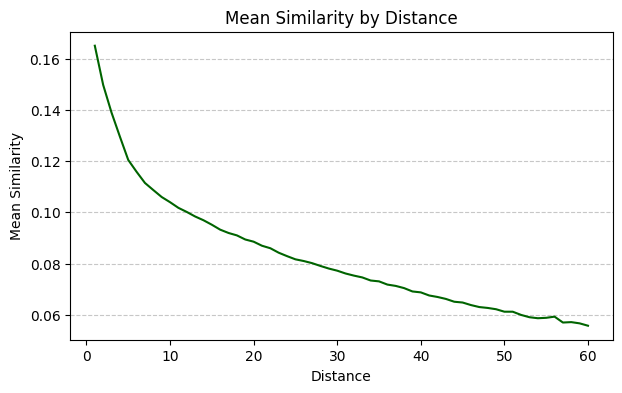

In [73]:
# Plot the mean similarity by distance (up to 60)
mean_similarity_by_distance_subset = mean_similarity_by_distance[mean_similarity_by_distance['distance'] <= 60]

plt.figure(figsize = (7, 4))
sns.lineplot(x = 'distance', y = 'similarity', data = mean_similarity_by_distance_subset, color = 'darkgreen')
plt.xlabel('Distance')
plt.ylabel('Mean Similarity')
plt.title('Mean Similarity by Distance')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

The line plot clearly shows that similarity scores decrease rapidly as the distance increases, confirming that closer sentences tend to have stronger semantic connections. This trend suggests that focusing similarity computations on close sentences is both computationally efficient and consistent with the characteristics of textual data.

### Implementation

Below is the Python implementation of the improved algorithm, which incorporates the window size $w$. We also adjust the `textrank_metrics_sparse` function into `textrank_metrics_sparse_w`, which applies this new version of the algorithm to a dataset of texts and evaluates its performance, including mean execution time and mean ROUGE scores.

In [74]:
def textrank_sparse_w(sentences_as_words, damping, threshold_conv, threshold_sim, w, max_iter = float('inf')):
    """
    Apply the TextRank algorithm with sparsification to rank sentences based on their similarity, limiting the similarity computation to sentences whose distance is <= w.

    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.
    - damping: float
        The damping factor (typically between 0.85 and 0.95), controlling the probability of randomly jumping to another sentence.
    - threshold_conv: float
        Threshold value for convergence in the power method.
    - threshold_sim: float
        Similarity threshold to consider an edge between two sentences.
    - w: int
        Maximum allowed distance between sentences to compute their similarity score.
    - max_iter: int
        Maximum number of iterations for the power method. Default is float('inf') (no limit).
    
    Returns:
    - list of tuple
        A ranked list of sentences based on their TextRank score, where each tuple contains
        the index of the sentence and its corresponding rank score.
    """

    # Compute the number of sentences
    n_sentences = len(sentences_as_words)
    
    # Initialize a sparse matrix using LIL format
    sparse_sim_matrix = lil_matrix((n_sentences, n_sentences))

    # Construct the sparse adjacency matrix based on sentence similarity
    for i, words_i in enumerate(sentences_as_words):
        end_idx = min(n_sentences, i + w + 1)  # Ensure we don't go beyond the last index
        for j in range(i, end_idx):
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # Only consider similarities above threshold_sim
            if similarity_ij > threshold_sim: 
                sparse_sim_matrix[i, j] = similarity_ij
                sparse_sim_matrix[j, i] = similarity_ij 
    
    # Convert to CSR format for efficient arithmetic operations
    sparse_sim_matrix = sparse_sim_matrix.tocsr()

    # Normalize the sparse adjacency matrix to make it stochastic
    row_sums = np.array(sparse_sim_matrix.sum(axis = 1)).flatten() + 1e-8
    sparse_sim_matrix = sparse_sim_matrix.multiply(1 / row_sums[:, np.newaxis])

    # Apply the power method
    transposed_matrix = sparse_sim_matrix.T   
    # Initialize the PageRank vector (all sentences have equal probability initially)
    p_vector = np.ones(n_sentences) / n_sentences
    # Random jump value (applied dynamically during each iteration)
    random_jump_value = (1.0 - damping) / n_sentences
    # Initialize the convergence value
    lambda_val = float('inf')

    iter_count = 0
    while lambda_val > threshold_conv and iter_count < max_iter:
        next_p = transposed_matrix.dot(p_vector)
        # Apply the random jump as part of the iteration
        next_p = damping * next_p + random_jump_value
        lambda_val = np.linalg.norm(next_p - p_vector)
        # Update the PageRank vector for the next iteration
        p_vector = next_p
        iter_count += 1

    # Rank the sentences based on their PageRank scores
    ranked_sentences = sorted(enumerate(p_vector), key = lambda x: x[1], reverse = True)

    return ranked_sentences

In [75]:
def textrank_metrics_sparse_w(df, num_sent_summary, damping, thresh_conv, thresh_sim, w, max_iter = float('inf'), stemming = True):
   '''
   This function applies the textrank_sparse_w function on a dataset of articles and evaluates its performance, including execution times and ROUGE scores.

   Parameters:
   - df: pandas.DataFrame 
      DataFrame containing articles and reference summaries. Must include preprocessed sentences.
   - num_sent_summary: int
      Number of sentences to include in the generated summary.
   - damping: float
      Damping factor for the Textrank algorithm.
   - thresh_conv: float
      Convergence threshold for Textrank.
   - thresh_sim: float
      Similarity threshold to consider an edge between two sentences.
   - w: int
      Maximum allowed distance between sentences to compute their similarity score.
   - max_iter: int, optional
      Maximum number of iterations for Textrank. Default is float('inf') (no limit).
   - stemming: bool, optional
      Flag to choose between stemming and lemmatization. Default is True (stemming).

   Returns:
   - results_metrics: pandas.DataFrame
      Pandas DataFrame with aggregated metrics including mean execution times and ROUGE scores.
   '''

   len_df = len(df)

   # Initialize numpy arrays to store metrics for each article
   textrank_times = np.zeros(len_df)  # Textrank execution times
   rouge_1 = np.zeros(len_df)  # ROUGE-1 F1 scores
   rouge_2 = np.zeros(len_df)  # ROUGE-2 F1 scores
   rouge_l = np.zeros(len_df)  # ROUGE-L F1 scores

   # Initialize the ROUGE metric for evaluating summaries
   rouge = Rouge()

   # Iterate over each article in the DataFrame
   for i, row in tqdm(df.iterrows(), total = len_df):
      
      # Extract article sentences and reference summary
      sentences = row['article_sent']
      reference_summary = row['highlights']
      # Use preprocessed sentences based on the stemming flag
      preprocessed_sentences = row['preproc_stem'] if stemming else row['preproc_lem']

      # Start measuring execution time
      start_time = time.time()
      # Apply Textrank
      ranked_sentences = textrank_sparse_w(preprocessed_sentences, damping, thresh_conv, thresh_sim, w, max_iter)
      # Measure execution time and store the result
      textrank_times[i] = time.time() - start_time

      # Generate the summary based on the top-ranked sentences
      summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
      candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])

      # Calculate ROUGE scores for the generated summary
      rouge_scores = rouge.get_scores(candidate_summary, reference_summary)[0]
      rouge_1[i] = rouge_scores['rouge-1']['f']
      rouge_2[i] = rouge_scores['rouge-2']['f']
      rouge_l[i] = rouge_scores['rouge-l']['f']

   # Aggregate results across all articles
   results_metrics = {
      'mean_exec_time': np.mean(textrank_times),  # Mean execution time of Textrank
      'rouge_1_mean': np.mean(rouge_1),  # Mean ROUGE-1 F1 score
      'rouge_2_mean': np.mean(rouge_2),  # Mean ROUGE-2 F1 score
      'rouge_l_mean': np.mean(rouge_l)  # Mean ROUGE-L F1 score
   }

   results_metrics = pd.DataFrame({k: [round(v, 4)] for k, v in results_metrics.items()})
   
   return results_metrics

### Choosing the window size $\textit{w}$

To determine the optimal value of $\textit{w}$ for our dataset, we evaluate the performance of the `textrank_sparse_w` function on `sample_df`, using various window sizes, specifically $w\in\{3,5,8,10,12,15\}$.  We stop at $\textit{w}= 15$ as this value is less than half the mean number of sentences per article in our dataset ($\approx 37.19$). For each value of $\textit{w}$, we apply the algorithm using the previously optimized parametrs, and measure both the mean execution time and the mean ROUGE scores.

In [76]:
# Initialize the selected parameters
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.35
max_iter = 8
# Define w values to test
w_values = [3, 5, 8, 10, 12, 15]

# Iterate over each element in w_values and store the results in a DataFrame
results_w = pd.DataFrame()
for w in w_values:
    results_metrics = textrank_metrics_sparse_w(sample_df, num_sent_summary, damping, thresh_conv, thresh_sim,
                                                w, max_iter, stemming = True)
    results_w = pd.concat([results_w, results_metrics], ignore_index = True)

results_w.insert(0, 'w', w_values)
results_w

100%|██████████| 31108/31108 [07:34<00:00, 68.38it/s]


,w,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,3,0.0042,0.2676,0.0823,0.2456
1,5,0.0053,0.2730,0.0855,0.2508
2,8,0.0069,0.2779,0.0883,0.2554
3,10,0.0078,0.2805,0.0898,0.2578
4,12,0.0087,0.2828,0.0913,0.2602
5,15,0.0097,0.2854,0.0931,0.2626


The results reveal a clear trade-off between execution time and summarization quality: as $\textit{w}$ increases, the ROUGE scores gradually improve, reflecting a more comprehensive consideration of sentence similarities. However, this comes at the cost of increased execution time.\
We choose as optimal window size $\textit{w} = 12$ since it balances efficiency and accuracy: the ROUGE scores are close to the highest values observed, indicating a robust summarization performance. Additionally, the mean execution time ($0.0087s$) remains manageable and only slightly higher than the one corresponding to $\textit{w}=10$.

We can now apply `textrank_sparse_w` to the whole dataset `df` using the optimized parameters and show the corresponding performance metrics.

In [77]:
# Initialize the optimized parameters
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.35
max_iter = 8
w = 12

# Apply textrank_sparse_w to the whole dataset and store the performance metrics
results_textrank_3 = textrank_metrics_sparse_w(df, num_sent_summary, damping, thresh_conv, thresh_sim, w, max_iter, stemming = True)

results_textrank_3

100%|██████████| 103700/103700 [30:11<00:00, 57.25it/s]  


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,0.0088,0.2829,0.0914,0.2601


### Dynamic $\textit{w}$

To further enhance computational efficiency, we propose a slight variation that makes the parameter $\textit{w}$ 'dynamic', meaning its value decreases as we progress through the text. This approach is motivated by the observation that the most important sentences tend to be located at the beginning of the text, especially in articles.

To verify this for our dataset, we analyze the positional frequencies of sentences selected by the functions `textrank` and `textrank_sparse`. The results, illustrated in the bar plots below, indicate that both algorithms consistently select more sentences from the initial positions of the text. Notice that we use the `sample_df`DataFrame to produce both plots.

textrank:

100%|██████████| 31108/31108 [08:55<00:00, 58.09it/s] 


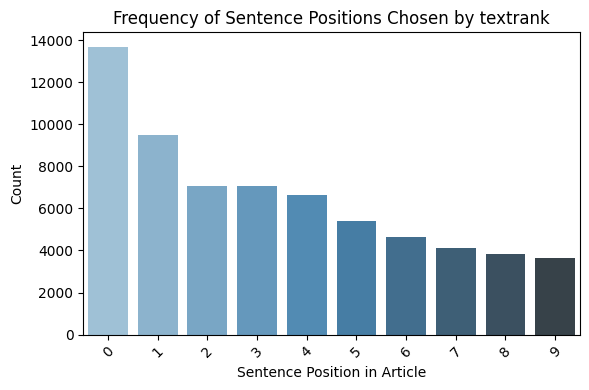

In [112]:
# Set parameters for TextRank algorithm
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
max_iter = 8

# Initialize a list to store the indices of the chosen sentences across all articles
chosen_sent_indices = []

# Iterate through each article in the sample_df DataFrame
for i in tqdm(range(len_sample_df)):
    
    # Extract preprocessed sentences
    preproc_sentences = sample_df.loc[i]['preproc_stem']
    
    # Run TextRank algorithm and get the ranking
    ranked_sentences, _ = textrank(preproc_sentences, damping, thresh_conv, max_iter)
    
    # Store the indices of the top num_sent_summary ranked sentences and add them to the list
    top_ranked_indices = [sent_index for sent_index, _ in ranked_sentences[:num_sent_summary]]
    chosen_sent_indices.extend(top_ranked_indices)

# Create a Counter to count how many times each sentence index was chosen
sent_position_counter = Counter(chosen_sent_indices)
# Convert the Counter to a DataFrame for easier plotting
df_sent_counts_1 = pd.DataFrame(list(sent_position_counter.items()), columns = ['sentence_position', 'count'])
# Sort by sentence position to ensure the plot is ordered
df_sent_counts_1 = df_sent_counts_1.sort_values('sentence_position').reset_index(drop = True)

# Plot a countplot of how often each sentence position is selected
plt.figure(figsize = (6, 4))
sns.barplot(x = 'sentence_position', y = 'count', data = df_sent_counts_1[0:10], palette = 'Blues_d') # Add hue = 'sentence_position' on google Colab

plt.title('Frequency of Sentence Positions Chosen by textrank')
plt.xlabel('Sentence Position in Article')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

textrank_sparse:

100%|██████████| 31108/31108 [08:43<00:00, 59.45it/s] 


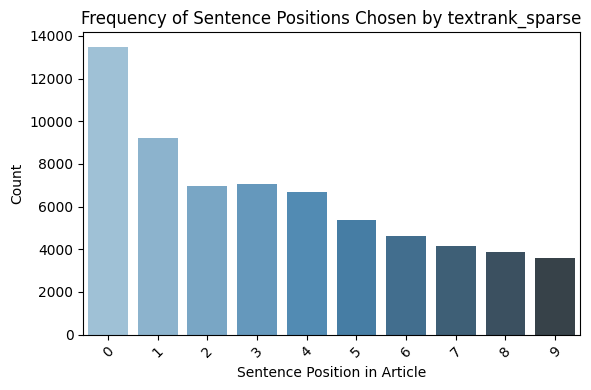

In [111]:
# Set parameters for textrank_sparse algorithm
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.35
max_iter = 8

# Initialize a list to store the indices of the chosen sentences across all articles
chosen_sent_indices = []

# Iterate through each article in the sample_df DataFrame
for i in tqdm(range(len_sample_df)):
    
    # Extract preprocessed sentences
    preproc_sentences = sample_df.loc[i]['preproc_stem']
    
    # Run textRank_sparse algorithm and get the ranking
    ranked_sentences = textrank_sparse(preproc_sentences, damping, thresh_conv, thresh_sim, max_iter)
    
    # Store the indices of the top num_sent_summary ranked sentences and add them to the list
    top_ranked_indices = [sent_index for sent_index, _ in ranked_sentences[:num_sent_summary]]
    chosen_sent_indices.extend(top_ranked_indices)

# Create a Counter to count how many times each sentence index was chosen
sent_position_counter = Counter(chosen_sent_indices)
# Convert the Counter to a DataFrame for easier plotting
df_sent_counts_2 = pd.DataFrame(list(sent_position_counter.items()), columns = ['sentence_position', 'count'])
# Sort by sentence position to ensure the plot is ordered
df_sent_counts_2 = df_sent_counts_2.sort_values('sentence_position').reset_index(drop = True)

# Plot a countplot of how often each sentence position is selected
plt.figure(figsize = (6, 4))
sns.barplot(x = 'sentence_position', y = 'count', data = df_sent_counts_2[0:10], palette = 'Blues_d') # Add hue = 'sentence_position' on google Colab

plt.title('Frequency of Sentence Positions Chosen by textrank_sparse')
plt.xlabel('Sentence Position in Article')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

The plots suggest that sentences near the beginning of a text are often the most relevant. Consequently, it is essential to compute almost all similarities involving these initial sentences. On the contrary, as we move further into the text, sentences tend to be less important for summarization. Hence, by gradually reducing $\textit{w}$, we can skip computing similarities between less relevant sentences, improving efficiency while maintaining a good performance.

The dynamic $\textit{w}$ is computed using a simple linear interpolation function that adjusts $\textit{w}$ based on the sentence's relative position in the text. Below are the functions needed to implement this variation.

In [80]:
def compute_dynamic_w(n_sentences, i, max_w, min_w = 1):
    """
    Compute a dynamic value of w based on the sentence position.
    
    Parameters:
    - n_sentences: int
       Total number of sentences in the article
    - i: int 
       Current sentence index
    - max_w: int 
       Maximum value of w
    - min_w: int 
       Minimum value of w

    Returns:
    - dynamic_w: int
       Dynamic value of w for the current sentence
    """
    # Calculate the relative position of the sentence in the article
    relative_position = i / (n_sentences - 1)
    
    # Compute w using a linear interpolation between max_w and min_w
    dynamic_w = int(max_w - (max_w - min_w) * relative_position)
    
    return max(dynamic_w, min_w)

def textrank_sparse_w_dynamic(sentences_as_words, damping, threshold_conv, threshold_sim, w, max_iter = float('inf')):
    """
    Apply the TextRank algorithm with sparsification to rank sentences based on their similarity, limiting the similarity computation to sentences whose distance is <= w, where w is adjusted dynamically.

    Parameters:
    - sentences_as_words: list of list of str
        Preprocessed sentences, each sentence is a list of words.
    - damping: float
        The damping factor (typically between 0.85 and 0.95), controlling the probability of randomly jumping to another sentence.
    - threshold_conv: float
        Threshold value for convergence in the power method.
    - threshold_sim: float
        Similarity threshold to consider an edge between two sentences.
    - w: int
        Maximum allowed distance between sentences to compute their similarity score.
    - max_iter: int
        Maximum number of iterations for the power method. Default is float('inf') (no limit).
    
    Returns:
    - list of tuple
        A ranked list of sentences based on their TextRank score, where each tuple contains
        the index of the sentence and its corresponding rank score.
    """

    # Compute the number of sentences
    n_sentences = len(sentences_as_words)

    # Store the initial w value
    max_w = w
    
    # Initialize a sparse matrix using LIL format
    sparse_sim_matrix = lil_matrix((n_sentences, n_sentences))

    # Construct the sparse adjacency matrix based on sentence similarity
    for i, words_i in enumerate(sentences_as_words):      
        w = compute_dynamic_w(n_sentences, i, max_w)
        end_idx = min(n_sentences, i + w + 1)  # Ensure we don't go beyond the last index
        for j in range(i, end_idx):
            similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
            # Only consider similarities above threshold_sim
            if similarity_ij > threshold_sim: 
                sparse_sim_matrix[i, j] = similarity_ij
                sparse_sim_matrix[j, i] = similarity_ij 
    
    # Convert to CSR format for efficient arithmetic operations
    sparse_sim_matrix = sparse_sim_matrix.tocsr()

    # Normalize the sparse adjacency matrix to make it stochastic
    row_sums = np.array(sparse_sim_matrix.sum(axis = 1)).flatten() + 1e-8
    sparse_sim_matrix = sparse_sim_matrix.multiply(1 / row_sums[:, np.newaxis])

    # Apply the power method
    transposed_matrix = sparse_sim_matrix.T   
    # Initialize the PageRank vector (all sentences have equal probability initially)
    p_vector = np.ones(n_sentences) / n_sentences
    # Random jump value (applied dynamically during each iteration)
    random_jump_value = (1.0 - damping) / n_sentences
    # Initialize the convergence value
    lambda_val = float('inf')

    iter_count = 0
    while lambda_val > threshold_conv and iter_count < max_iter:
        next_p = transposed_matrix.dot(p_vector)
        # Apply the random jump as part of the iteration
        next_p = damping * next_p + random_jump_value
        lambda_val = np.linalg.norm(next_p - p_vector)
        # Update the PageRank vector for the next iteration
        p_vector = next_p
        iter_count += 1

    # Rank the sentences based on their PageRank scores
    ranked_sentences = sorted(enumerate(p_vector), key = lambda x: x[1], reverse = True)

    return ranked_sentences

In [81]:
def textrank_metrics_sparse_w_dynamic(df, num_sent_summary, damping, thresh_conv, thresh_sim, w, max_iter = float('inf'), stemming = True):
   '''
   This function applies textrank_sparse_w_dynamic on a dataset of articles and evaluates its performance, including execution times and ROUGE scores.

   Parameters:
   - df: pandas.DataFrame 
      DataFrame containing articles and reference summaries. Must include preprocessed sentences.
   - num_sent_summary: int
      Number of sentences to include in the generated summary.
   - damping: float
      Damping factor for the Textrank algorithm.
   - thresh_conv: float
      Convergence threshold for Textrank.
   - thresh_sim: float
      Similarity threshold to consider an edge between two sentences.
   - w: int
      Maximum allowed distance between sentences to compute their similarity score.
   - max_iter: int, optional
      Maximum number of iterations for Textrank. Default is float('inf') (no limit).
   - stemming: bool, optional
      Flag to choose between stemming and lemmatization. Default is True (stemming).

   Returns:
   - results_metrics: pandas.DataFrame
      Pandas DataFrame with aggregated metrics including mean execution times and ROUGE scores.
   '''

   len_df = len(df)

   # Initialize numpy arrays to store metrics for each article
   textrank_times = np.zeros(len_df)  # Textrank execution times
   rouge_1 = np.zeros(len_df)  # ROUGE-1 F1 scores
   rouge_2 = np.zeros(len_df)  # ROUGE-2 F1 scores
   rouge_l = np.zeros(len_df)  # ROUGE-L F1 scores

   # Initialize the ROUGE metric for evaluating summaries
   rouge = Rouge()

   # Iterate over each article in the DataFrame
   for i, row in tqdm(df.iterrows(), total = len_df):
      
      # Extract article sentences and reference summary
      sentences = row['article_sent']
      reference_summary = row['highlights']
      # Use preprocessed sentences based on the stemming flag
      preprocessed_sentences = row['preproc_stem'] if stemming else row['preproc_lem']

      # Start measuring execution time
      start_time = time.time()
      # Apply Textrank
      ranked_sentences = textrank_sparse_w_dynamic(preprocessed_sentences, damping, thresh_conv, thresh_sim, w, max_iter)
      # Measure execution time and store the result
      textrank_times[i] = time.time() - start_time

      # Generate the summary based on the top-ranked sentences
      summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
      candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])

      # Calculate ROUGE scores for the generated summary
      rouge_scores = rouge.get_scores(candidate_summary, reference_summary)[0]
      rouge_1[i] = rouge_scores['rouge-1']['f']
      rouge_2[i] = rouge_scores['rouge-2']['f']
      rouge_l[i] = rouge_scores['rouge-l']['f']

   # Aggregate results across all articles
   results_metrics = {
      'mean_exec_time': np.mean(textrank_times),  # Mean execution time of Textrank
      'rouge_1_mean': np.mean(rouge_1),  # Mean ROUGE-1 F1 score
      'rouge_2_mean': np.mean(rouge_2),  # Mean ROUGE-2 F1 score
      'rouge_l_mean': np.mean(rouge_l)  # Mean ROUGE-L F1 score
   }

   results_metrics = pd.DataFrame({k: [round(v, 4)] for k, v in results_metrics.items()})
   
   return results_metrics

We can now apply the `textrank_sparse_w_dynamic` function to the whole dataset `df` using the optimized parameters and a dynamic window size starting from $\textit{w} = 12$. Below are the corresponding performance metrics.

In [82]:
# Initialize the optimized parameters
num_sent_summary = 4
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.35
max_iter = 8
w = 12

# Apply textrank_sparse_w_dynamic to the whole dataset and store the performance metrics
results_textrank_4 = textrank_metrics_sparse_w_dynamic(df, num_sent_summary, damping, thresh_conv, thresh_sim, w, max_iter, stemming = True)

results_textrank_4

100%|██████████| 103700/103700 [24:54<00:00, 69.38it/s]  


,mean_exec_time,rouge_1_mean,rouge_2_mean,rouge_l_mean
0,0.0068,0.2884,0.0954,0.2655


# Performance comparison

To evaluate the performance of the introduced improvements and compare them with the original `textrank` function, we first compute the mean peak memory usage using the `tracemalloc` library. We measure it on the `sample_df` DataFrame due to computational constraints.

In [83]:
def get_textrank_memory(df, damping, thresh_conv, thresh_sim = None, w = None, max_iter = float('inf'), 
                        stemming = True, alg_number = 1):
    '''
    Function to compute the mean memory usage of the TextRank algorithm (or its variants) on a given dataset of articles. It uses the tracemalloc library.

    Parameters:
    - df: pandas.DataFrame 
        DataFrame containing articles and reference summaries. Must include preprocessed sentences.
    - damping: float
        Damping factor for the Textrank algorithm.
    - thresh_conv: float
        Convergence threshold for Textrank.
    - thresh_sim: float, optional
        Similarity threshold to consider an edge between two sentences.
    - w: int, optional
        Maximum allowed distance between sentences to compute their similarity score.
    - max_iter: int, optional
        Maximum number of iterations for Textrank. Default is float('inf') (no limit).
    - stemming: bool, optional
        Flag to choose between stemming and lemmatization. Default is True (stemming).
    - alg_number: int, optional
        Algorithm selector. If 1, uses standard TextRank. If 2, uses textrank_sparse. If 3, 
        uses textrank_sparse_w. If 4, uses textrank_sparse_w_dynamic.

    Returns:
    - mean_memory_usage: float
        The mean peak memory usage (in MB) during the execution of the TextRank algorithm over all articles.
    '''   
    
    len_df = len(df)

    # Initialize an array to store memory usage for each article
    textrank_memory = np.zeros(len_df)

    # Iterate over each article in the df DataFrame
    for i, row in tqdm(df.iterrows(), total = len_df):
        
        # Use preprocessed sentences based on the stemming flag
        preproc_sentences = row['preproc_stem'] if stemming else row['preproc_lem']

        # Start measuring memory usage using tracemalloc
        tracemalloc.start()
        # Apply the appropriate version of the TextRank algorithm based on 'alg_number'
        if alg_number == 1:
           _, _ = textrank(preproc_sentences, damping, thresh_conv, max_iter)
        elif alg_number == 2:
            _ = textrank_sparse(preproc_sentences, damping, thresh_conv, thresh_sim, max_iter)
        elif alg_number == 3:
            _ = textrank_sparse_w(preproc_sentences, damping, thresh_conv, thresh_sim, w, max_iter)
        else:
            _ = textrank_sparse_w_dynamic(preproc_sentences, damping, thresh_conv, thresh_sim, w, max_iter)
             
        # Get peak memory usage during algorithm execution
        _, peak = tracemalloc.get_traced_memory()
        textrank_memory[i] = peak / 1024 / 1024 # Convert from bytes to MB
        # Stop tracing memory after each article
        tracemalloc.stop()

    # Calculate the mean memory usage across all articles
    mean_memory_usage = np.mean(textrank_memory)

    return mean_memory_usage

In [84]:
# Initialize the optimized parameters
damping = 0.85
thresh_conv = 1e-3
thresh_sim = 0.3
max_iter = 8
w = 12

In [110]:
# Mean peak memory usage with textrank
mean_memory_usage_1 = get_textrank_memory(sample_df, damping, thresh_conv, max_iter = max_iter, stemming = True, alg_number = 1)
print(f"The average memory used by textrank algorithm is {mean_memory_usage_1:.4f} MB per article.")

100%|██████████| 31108/31108 [31:21<00:00, 16.53it/s]


The average memory used by textrank algorithm is 0.0577 MB per article.


In [86]:
# Mean peak memory usage with textrank_sparse
mean_memory_usage_2 = get_textrank_memory(sample_df, damping, thresh_conv, thresh_sim, max_iter = max_iter, stemming = True, alg_number = 2)
print(f"The average memory used by textrank_sparse algorithm is {mean_memory_usage_2:.4f} MB per article.")

100%|██████████| 31108/31108 [31:48<00:00, 16.30it/s]

The average memory used by textrank_sparse algorithm is 0.0187 MB per article.


In [87]:
# Mean peak memory usage with textrank_sparse_w
mean_memory_usage_3 = get_textrank_memory(sample_df, damping, thresh_conv, thresh_sim, w, max_iter = max_iter, stemming = True, alg_number = 3)
print(f"The average memory used by textrank_sparse_w algorithm is {mean_memory_usage_3:.4f} MB per article.")

100%|██████████| 31108/31108 [17:03<00:00, 30.40it/s]

The average memory used by textrank_sparse_w algorithm is 0.0134 MB per article.


In [88]:
# Mean peak memory usage with textrank_sparse_w_dynamic
mean_memory_usage_4 = get_textrank_memory(sample_df, damping, thresh_conv, thresh_sim, w, max_iter = max_iter, stemming = True, alg_number = 4)
print(f"The average memory used by textrank_sparse_w_dynamic algorithm is {mean_memory_usage_3:.4f} MB per article.")

100%|██████████| 31108/31108 [12:24<00:00, 41.77it/s]


The average memory used by textrank_sparse_w_dynamic algorithm is 0.0134 MB per article.


Below is a bar plot that summarizes the results and compare the mean peak memory usage across the different TextRank versions.

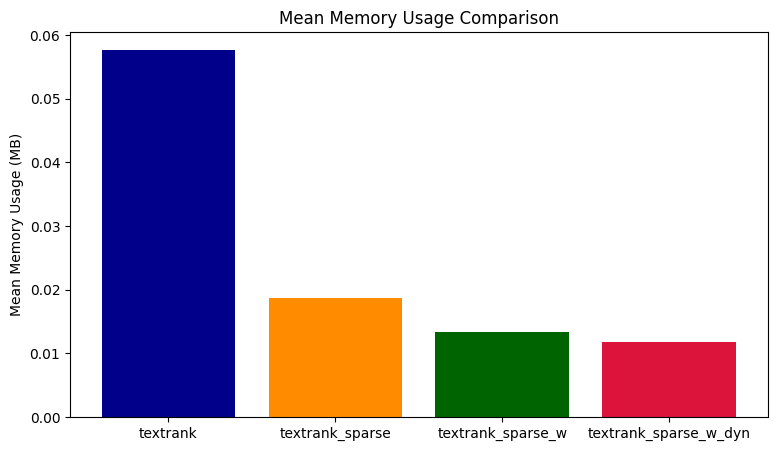

In [106]:
algorithms = ['textrank', 'textrank_sparse', 'textrank_sparse_w', 'textrank_sparse_w_dyn']

# Store mean memory usages in a list
mean_memory_usages = [mean_memory_usage_1, mean_memory_usage_2, mean_memory_usage_3, mean_memory_usage_4]

# Plot 1: Mean Memory Usage Comparison
plt.figure(figsize = (9, 5))
plt.bar(algorithms, mean_memory_usages, color = ['darkblue', 'darkorange', 'darkgreen', 'crimson'])
plt.ylabel('Mean Memory Usage (MB)')
plt.title('Mean Memory Usage Comparison')
plt.show()

We also display for comparison the mean execution times and the mean ROUGE scores across the different TextRank versions.

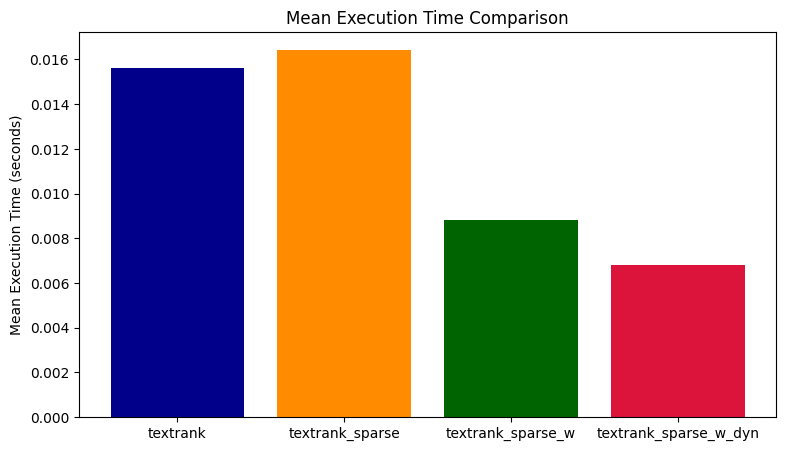

In [105]:
# Extract mean execution times and store them in a list
mean_times = [results_textrank_1['mean_exec_time'][0], results_textrank_2['mean_exec_time'][0], 
              results_textrank_3['mean_exec_time'][0], results_textrank_4['mean_exec_time'][0]]

# Plot 2: Mean Execution Time Comparison
plt.figure(figsize = (9, 5))
plt.bar(algorithms, mean_times, color = ['darkblue', 'darkorange', 'darkgreen', 'crimson'])
plt.ylabel('Mean Execution Time (seconds)')
plt.title('Mean Execution Time Comparison')
plt.show()

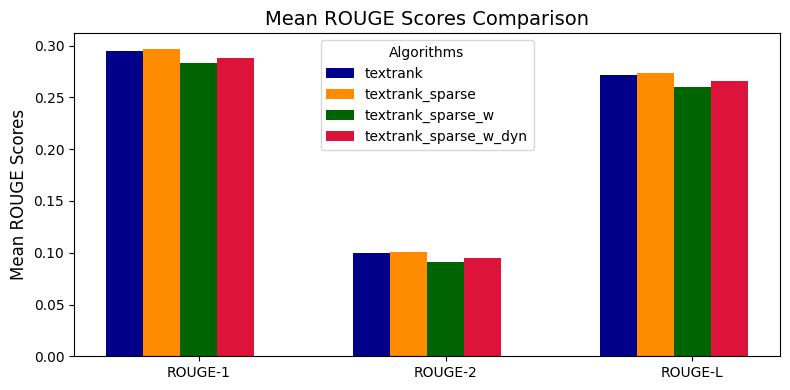

In [108]:
# Extract mean rouge scores and store them in lists
rouge_1_scores = [results_textrank_1['rouge_1_mean'][0], results_textrank_2['rouge_1_mean'][0],
                  results_textrank_3['rouge_1_mean'][0], results_textrank_4['rouge_1_mean'][0]]
rouge_2_scores = [results_textrank_1['rouge_2_mean'][0], results_textrank_2['rouge_2_mean'][0],
                  results_textrank_3['rouge_2_mean'][0], results_textrank_4['rouge_2_mean'][0]]
rouge_l_scores = [results_textrank_1['rouge_l_mean'][0], results_textrank_2['rouge_l_mean'][0],
                  results_textrank_3['rouge_l_mean'][0], results_textrank_4['rouge_l_mean'][0]]

# Plot 3: Mean ROUGE Scores Comparison
# Set bar width and X locations for ROUGE measures
bar_width = 0.15
rouge_measures = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
x = np.arange(len(rouge_measures))

fig, ax = plt.subplots(figsize = (8, 4))

# Set bar colors
colors = ['darkblue', 'darkorange', 'darkgreen', 'crimson']

# Plot bars for each algorithm under each ROUGE measure
for i, algorithm in enumerate(algorithms):
    # Compute the offset for each algorithm to adjust the bar positions
    offset = (i - len(algorithms) / 2) * bar_width
    # Plot bars with the calculated offset for each algorithm, setting the appropriate width and color
    ax.bar(x + offset, [rouge_1_scores[i], rouge_2_scores[i], rouge_l_scores[i]], 
           width = bar_width, label = algorithm, color = colors[i])
    
# Add labels and title
ax.set_ylabel('Mean ROUGE Scores', fontsize = 12)
ax.set_title('Mean ROUGE Scores Comparison', fontsize = 14)
# Set x-axis tick labels to ROUGE measures
ax.set_xticks(x)
ax.set_xticklabels(rouge_measures)

ax.legend(title = "Algorithms")
plt.tight_layout()
plt.show()

# Toy example

Here, we verify the accuracy of the computations performed for the toy example presented in the report.

In [93]:
text = "Climate change is causing more intense and frequent droughts in many regions, impacting water availability for various sectors, including agriculture and natural ecosystems. Indeed, these environmental changes create major challenges for farmers, who depend on stable water supplies to grow crops, raise livestock, and maintain agricultural productivity. Furthermore, natural ecosystems have become increasingly vulnerable to temperature fluctuations and extreme weather, affecting biodiversity. Many species, for example, struggle to adapt to the rapid changes and risk extinction as conditions change unpredictably. Scientists warn that food production may suffer, as growing seasons become increasingly unpredictable due to climate instability. Rising sea levels also pose risks to coastal ecosystems and threaten nearby human communities. In addition, agricultural yields are expected to decline if extreme weather events continue to rise in frequency and intensity. Therefore, conserving biodiversity and supporting resilient ecosystems is essential for sustaining both agriculture and food security under these rapidly changing conditions."

# Store the selected parameters
damping = 0.85
threshold_conv = 1e-2
max_iter = float('inf')

1) Text preprocessing

In [94]:
# Tokenize the text into sentences
sentences = nltk.sent_tokenize(text)
# Preprocess the sentences using preprocess_function with lemmatization
sentences_as_words = preprocess_function(sentences, stemming = False)
# Save the number of sentences in the text
n_sentences = len(sentences_as_words)

for i in range(n_sentences):
    print(sentences_as_words[i])

['climate', 'change', 'cause', 'intense', 'frequent', 'drought', 'many', 'region', 'impact', 'water', 'availability', 'various', 'sector', 'include', 'agriculture', 'natural', 'ecosystem']
['indeed', 'environmental', 'change', 'create', 'major', 'challenge', 'farmer', 'depend', 'stable', 'water', 'supply', 'grow', 'crop', 'raise', 'livestock', 'maintain', 'agricultural', 'productivity']
['furthermore', 'natural', 'ecosystem', 'become', 'increasingly', 'vulnerable', 'temperature', 'fluctuation', 'extreme', 'weather', 'affect', 'biodiversity']
['many', 'specie', 'example', 'struggle', 'adapt', 'rapid', 'change', 'risk', 'extinction', 'condition', 'change', 'unpredictably']
['scientist', 'warn', 'food', 'production', 'may', 'suffer', 'grow', 'season', 'become', 'increasingly', 'unpredictable', 'due', 'climate', 'instability']
['rise', 'sea', 'level', 'also', 'pose', 'risk', 'coastal', 'ecosystem', 'threaten', 'nearby', 'human', 'community']
['addition', 'agricultural', 'yield', 'expect', 

2) Similarity calculation and graph construction

In [95]:
# Initialize an adjacency matrix
similarity_matrix = np.zeros((n_sentences, n_sentences))

# Fill the similarity matrix with similarity scores
for i, words_i in enumerate(sentences_as_words):
    for j in range(i, n_sentences):
        similarity_ij = sentence_similarity(words_i, sentences_as_words[j])
        # The matrix is symmetric, so similarity_matrix[i, j] is equal to similarity_matrix[j, i]
        similarity_matrix[i, j] = similarity_ij
        similarity_matrix[j, i] = similarity_ij

# Display the adjacency matrix
display(np.round(similarity_matrix, 2))

array([[3.  , 0.35, 0.38, 0.38, 0.18, 0.19, 0.  , 0.55],
       [0.35, 3.11, 0.  , 0.19, 0.18, 0.  , 0.19, 0.18],
       [0.38, 0.  , 2.41, 0.  , 0.39, 0.2 , 0.4 , 0.39],
       [0.38, 0.19, 0.  , 2.41, 0.  , 0.2 , 0.  , 0.39],
       [0.18, 0.18, 0.39, 0.  , 2.65, 0.  , 0.  , 0.19],
       [0.19, 0.  , 0.2 , 0.2 , 0.  , 2.41, 0.2 , 0.2 ],
       [0.  , 0.19, 0.4 , 0.  , 0.  , 0.2 , 2.41, 0.  ],
       [0.55, 0.18, 0.39, 0.39, 0.19, 0.2 , 0.  , 2.65]])

3) Normalization and PageRank computation

In [96]:
# Normalize the similarity matrix to make it a stochastic matrix
row_sums = similarity_matrix.sum(axis = 1) + 1e-8  # Add a constant to prevent division by 0
similarity_matrix = np.divide(similarity_matrix, row_sums[:, np.newaxis])
# Display the normalized similarity matrix
display(np.round(similarity_matrix, 2))

array([[0.6 , 0.07, 0.07, 0.07, 0.04, 0.04, 0.  , 0.11],
       [0.08, 0.74, 0.  , 0.04, 0.04, 0.  , 0.04, 0.04],
       [0.09, 0.  , 0.58, 0.  , 0.09, 0.05, 0.1 , 0.09],
       [0.11, 0.05, 0.  , 0.68, 0.  , 0.06, 0.  , 0.11],
       [0.05, 0.05, 0.11, 0.  , 0.74, 0.  , 0.  , 0.05],
       [0.06, 0.  , 0.06, 0.06, 0.  , 0.71, 0.06, 0.06],
       [0.  , 0.06, 0.13, 0.  , 0.  , 0.06, 0.75, 0.  ],
       [0.12, 0.04, 0.09, 0.09, 0.04, 0.04, 0.  , 0.58]])

In [97]:
# Apply the damping factor to get the adjusted transition matrix
similarity_matrix = np.full((n_sentences, n_sentences), (1. - damping) / n_sentences) + damping * similarity_matrix
# Display the transition matrix
display(np.round(similarity_matrix, 2))

array([[0.53, 0.08, 0.08, 0.08, 0.05, 0.05, 0.02, 0.11],
       [0.09, 0.65, 0.02, 0.06, 0.06, 0.02, 0.06, 0.06],
       [0.1 , 0.02, 0.51, 0.02, 0.1 , 0.06, 0.1 , 0.1 ],
       [0.11, 0.06, 0.02, 0.59, 0.02, 0.07, 0.02, 0.11],
       [0.06, 0.06, 0.11, 0.02, 0.65, 0.02, 0.02, 0.06],
       [0.07, 0.02, 0.07, 0.07, 0.02, 0.62, 0.07, 0.07],
       [0.02, 0.07, 0.13, 0.02, 0.02, 0.07, 0.66, 0.02],
       [0.12, 0.05, 0.09, 0.09, 0.05, 0.06, 0.02, 0.51]])

In [98]:
# Apply the power method
transposed_matrix = similarity_matrix.T
# Initialize the PageRank vector (all sentences have equal probability initially)
p_vector = np.ones(n_sentences) / n_sentences
# Initialize the convergence value
lambda_val = float('inf')

iter_count = 0
while lambda_val > threshold_conv and iter_count < max_iter:
    next_p = np.dot(transposed_matrix, p_vector)
    print(f"next_p =", np.round(next_p,3))
    lambda_val = np.linalg.norm(next_p - p_vector)
    print(f"lambda_val =", np.round(lambda_val,3), "\n")
    # Update the PageRank vector for the next iteration
    p_vector = next_p
    iter_count += 1

next_p = [0.136 0.126 0.128 0.119 0.12  0.12  0.12  0.13 ]
lambda_val = 0.016 

next_p = [0.141 0.127 0.13  0.116 0.118 0.118 0.117 0.133]
lambda_val = 0.008 



4) Summary generation

In [99]:
# Rank the sentences based on their PageRank scores
ranked_sentences = sorted(enumerate(p_vector), key = lambda x: x[1], reverse = True)
ranked_sentences

[(0, 0.1413837994091195),
 (7, 0.13302827971373588),
 (2, 0.1299853441544383),
 (1, 0.12712240336927383),
 (5, 0.11789465352960636),
 (4, 0.11759429897721413),
 (6, 0.11698482435410607),
 (3, 0.11600639212577396)]

In [100]:
# Generate the summary based on the top-ranked sentences
summary_indices = [index for index, _ in ranked_sentences[:num_sent_summary]]
candidate_summary = " ".join([sentences[index] for index in sorted(summary_indices)])
candidate_summary

'Climate change is causing more intense and frequent droughts in many regions, impacting water availability for various sectors, including agriculture and natural ecosystems. Indeed, these environmental changes create major challenges for farmers, who depend on stable water supplies to grow crops, raise livestock, and maintain agricultural productivity. Furthermore, natural ecosystems have become increasingly vulnerable to temperature fluctuations and extreme weather, affecting biodiversity. Therefore, conserving biodiversity and supporting resilient ecosystems is essential for sustaining both agriculture and food security under these rapidly changing conditions.'